# Relating office jobs to office space for space per worker calculations

We need estimates for space per worker for modeling in BAUS, or employment densities on average in a county or superdistrict. To that end we need job data and building data, and a geographic relation between the two. We are focused on jobs and occupied space, and the subset of jobs prone to hanging out in office buildings, so we need info on occuped office space, and office jobs. For the former, we use CoStar, from which we have time series of occupancy / vacancy by building type. For the latter we tried first ACS data, and then switched to BLS QCEW data mainly because the subsetting to office jobs is based on 3-digit NAICS detail, not available in the ACS data.

## Costar
Starting problem: We are interested in using a vacancy timeseries from CoStar. The timeseries doesn't contain a variable for jurisdiction or counties natively - but they have submarket identifiers as geography markers. What are those, and how do they relate spatially to other geographies of interest for which we have data (jurisdictions, counties)? 

Costar doesn't share shapefiles so we instead need to infer from other file sources. As it happens we have the disaggregate CoStar buildings data data harvested from 2022 - those are lat / long point data, with submarket attributes. 

Using those points with a submarket attribute, we are looking to create a continuous surface of submarkets based on those point data.

Downstream, we relate sumbarkets to jurisdictions and counties to be able to monitor vacancies in relation to place-of-work employment levels.



In [ ]:
import getpass
import sys
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import feather as ft
import os
import json
import sys
import statsmodels.api as sm

from scipy.spatial import Voronoi
from shapely.geometry import Polygon
from sklearn.neighbors import KDTree

import h3
from tobler.util import h3fy
# this is a neat library, expanding on h3 functions, and adding a handy df.h3 accessor
import h3pandas

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
from matplotlib.colorbar import ColorbarBase

In [1]:
user = getpass.getuser()
utils_path = os.path.join('/Users', user, 'Documents',
                          'GitHub', 'dvutils')
sys.path.insert(0, utils_path)
from utils_io import *

/Users/aolsen/opt/anaconda3/envs/geo_env_2/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/646559160.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shap

# Helper functions and lookups

In [2]:
superdist_records = np.array([(0, 15, 'Tri Valley'), (1, 16, 'Fremont'),
                              (2, 17, 'S Leandro Hayward'), (3,
                                                             18, 'Oakland Alameda'),
                              (4, 19, 'Berkeley Eville'), (5,
                                                           20, 'Richmond Pinole'),
                              (6, 21, 'Martinez Concord'), (7, 22, 'Lamorinda WC'),
                              (8, 23, 'S Ramon Danville'), (9,
                                                            24, 'East Contra Costa'),
                              (10, 32, 'Northern Marin'), (11, 33, 'Central Marin'),
                              (12, 34, 'Southern Marin'), (13,
                                                           27, 'Napa City and S'),
                              (14, 28, 'Napa Remainder'), (15,  1, 'SF NE'),
                              (16,  2, 'SF NW'), (17,  3,
                                                  'SF S SE'), (18,  4, 'SF SW'),
                              (19,  5, 'Daly City Millbrae'), (20,  6, 'San Mateo'),
                              (21,  7, 'Redwood City'), (22,  8, 'Palo Alto'),
                              (23,  9, 'Golden Triangle'), (24, 10, 'West San Jose'),
                              (25, 11, 'San Jose CBD'), (26, 12, 'East San Jose'),
                              (27, 13, 'South San Jose'), (28,
                                                           14, 'SE Snta Clara Cnty'),
                              (29, 25, 'Vallejo Benicia'), (30,
                                                            26, 'Solano Remainder'),
                              (31, 29, 'Southern Sonoma'), (32,
                                                            30, 'Santa Rosa Area'),
                              (33, 31, 'Northern Sonoma')],
                             dtype=[('index', '<i8'), ('number', '<i8'), ('name', 'O')])
superdist_records = pd.DataFrame.from_records(
    superdist_records).set_index('number').name



In [3]:
# county fips mapping

bayareafips_full = {'06001': 'Alameda', '06013': 'Contra Costa', '06041': 'Marin', '06055': 'Napa',
                    '06075': 'San Francisco', '06081': 'San Mateo', '06085': 'Santa Clara', '06097': 'Sonoma', '06095': 'Solano'}

In [4]:
# def group_and_aggregate(data, groupby_vars, agg_dict):
#     grouped = data.groupby(groupby_vars)
#     grouped_df = grouped.agg(agg_dict)
#     grouped_df.columns = grouped_df.columns.droplevel(1)
#     return grouped_df

In [5]:
def empl_density(x, sqft_var, job_var):
    """
    Calculates employee density statistics for a given DataFrame.

    Args:
        x: A pandas DataFrame containing square footage and job data.
        sqft_var: The name of the column containing square footage data (e.g., "sqft").
        job_var: The name of the column containing job data (e.g., "job_count").

    Returns:
        A pandas Series object containing the following statistics:
            * sqft_sum: Total square footage.
            * emp_sum: Total number of jobs.
            * dens_avg: Average density (sqft / jobs).
    """

    sqft_sum = x[sqft_var].sum()
    emp_sum = x[job_var].sum()
    dens_avg = sqft_sum/emp_sum
    dens_median = (x[sqft_var] / x[job_var]).median()
    recs = len(x)
    return pd.Series([sqft_sum,
                      emp_sum,
                      dens_avg,
                      dens_median,
                      recs],
                     index=['sqft_sum', 'emp_sum', 'dens_avg', 'dens_median', 'records'])

In [6]:
def generate_jurisdictions_hex(resolution):
    """
    Generate hexagon-based jurisdictions based on a given resolution.

    Parameters:
    - resolution (int): The resolution level for the hexagons.

    Returns:
    - DataFrame: DataFrame containing hexagon-based jurisdictions.
    """
    jurisdictions_hex = jurisdictions_2020.h3.polyfill(
        resolution=resolution, explode=True)
    jurisdictions_hex = jurisdictions_hex.dropna(subset=['h3_polyfill'])
    jurisdictions_hex['geometry'] = jurisdictions_hex.h3_polyfill.dropna().apply(
        h3pol)
    jurisdictions_hex = jurisdictions_hex.set_geometry('geometry')
    return jurisdictions_hex

# jurisdictions_hex_7 = generate_jurisdictions_hex(7)
# jurisdictions_hex_8 = generate_jurisdictions_hex(8)

In [7]:
pct = lambda x: x/x.sum()

In [8]:
# def h3pol(h3_id):
#     return Polygon(h3.h3_to_geo_boundary(h3_id, geo_json=True))

In [9]:
# convenience groupby turning a gdf geoms by group into clean hexagons

def generate_h3_within_polys(poly_data, grps=[], resolution=8):
    """
    Generate H3 indexes for jurisdictions based on the provided data.

    Parameters:
    - poly_data (DataFrame): DataFrame containing 'county' and 'jurisdicti' columns.
    - resolution (int): Resolution parameter for H3 indexing. Defaults to 8.

    Returns:
    - DataFrame: DataFrame with H3 indexes for jurisdictions, indexed by 'county' and 'juris'.
    """
    juris_h3 = {}
    for nme, dta in poly_data.groupby(grps):
        juris_h3[nme] = h3fy(dta, resolution=resolution)
    juris_h3 = pd.concat(juris_h3, names=grps).reset_index()
    return juris_h3

# Get geodata

In [10]:
tract_path = f'/Users/{user}/Box/Modeling and Surveys/Census/2020/tracts/censustracts_bayarea_2020_v2.shp'

tracts2020 = gpd.read_file(
    tract_path).to_crs('EPSG:26910')

In [11]:
tracts2020['county_name'] = tracts2020.GEOID.str.slice(
    0, 5).map(bayareafips_full)

In [12]:
# get county geoms
county_shapes = tracts2020.dissolve(['county_name']).reset_index()[
    ['county_name', 'geometry']]

In [13]:
# aggregate to whole region
region_shape = gpd.GeoSeries(county_shapes.unary_union).reset_index()
region_shape.columns = ['index', 'geometry']
region_shape = region_shape.set_geometry('geometry')
region_shape = region_shape.set_crs('EPSG:26910')

In [14]:
jurisdictions_2020 = gpd.read_file(filename=f'/Users/{user}/Box/DataViz Projects/Data Services/BASIS/Data Processing/Administrative Boundaries/Jurisdiction Boundaries/TIGER 2020/Jurisdiction_Boundary_Database.gdb',
                                   layer='Bay_Area_Incorp_Places_Counties_TIGER_2020', driver='FileGDB').rename(columns={'COUNTY': 'county', 'JURISDICTION': 'juris'}).to_crs('EPSG:3857')

# standardize name by removing suffix parts

jurisdictions_2020.county = jurisdictions_2020.county.str.replace(
    ' County', '').str.strip()

jurisdictions_2020['juris'] = jurisdictions_2020['jurisdicti'] = jurisdictions_2020.juris.str.replace(
    ' town| city', '').str.strip()

jurisdictions_2020['area'] = jurisdictions_2020.area

# lowercase col names
jurisdictions_2020.columns = jurisdictions_2020.columns.str.lower()

jurisdictions_2020_clipped = gpd.clip(jurisdictions_2020.to_crs(
    'EPSG:4326'), region_shape.to_crs('EPSG:4326'))


/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/2951952371.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  jurisdictions_2020['juris'] = jurisdictions_2020['jurisdicti'] = jurisdictions_2020.juris.str.replace(
/Users/aolsen/opt/anaconda3/envs/geo_env_2/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [15]:
zones_path = f'/Users/{user}/Box/Modeling and Surveys/Urban Modeling/Spatial/Zones/TAZ1454/zones1454.shp'

zones = gpd.read_file(zones_path).to_crs('EPSG:26910')
zones['geom_pt'] = zones.representative_point()
zones['county_name'] = zones.fipsstco.map(bayareafips_full)

zones['region'] = 'Bay Area'

In [16]:
county_x_superdist = zones.groupby(
    ['county_name', 'superdistr']).size().reset_index(1).superdistr

superdistricts = zones.dissolve('superdistr', as_index=False).iloc[:, :2]

region = zones.dissolve('region', as_index=False).iloc[:, :2]

superdist_to_county = zones.groupby(
    'superdistr').fipsstco.first().map(bayareafips_full)

<AxesSubplot: >

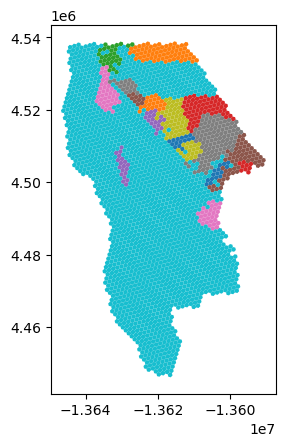

In [17]:
# hex-ify jurisdictions at different resolutions

jurisdictions_hex_8 = generate_h3_within_polys(
    jurisdictions_2020, grps=['county', 'jurisdicti'], resolution=8)


jurisdictions_hex_7 = generate_h3_within_polys(
    jurisdictions_2020,  grps=['county', 'jurisdicti'], resolution=7)

# check out san mateo county
jurisdictions_hex_8.query('county=="San Mateo"').plot(column='jurisdicti')

In [18]:
# # now, get hex grids, at different resolutions - 7 is smaller

# bayarea_hex_7 = h3fy(region_shape, resolution=7)
# bayarea_hex_6 = h3fy(region_shape, resolution=6)

# Get CoStar point data

In [19]:
spaces = pull_df_from_socrata('ac2e-es3n')

pulling data in 5 chunks of 17000 rows each
pulling chunk 0
pulling chunk 1
pulling chunk 2
pulling chunk 3
pulling chunk 4
took 12.5748 seconds


In [20]:
spaces['geometry'] = gpd.points_from_xy(x=spaces.longitude,y=spaces.latitude,crs='EPSG:4326')
spaces = spaces.set_geometry('geometry')

In [21]:
spaces['property_count'] = 1

In [22]:
spaces['x'] = spaces.to_crs('EPSG:26910').geometry.x
spaces['y'] = spaces.to_crs('EPSG:26910').geometry.y

# Neighborhood generation

## Alternative: Neighborhoods from DBSCAN algorithm

These just identify clusters within a fixed search threshold. Deterministic.



In [23]:
from sklearn.cluster import DBSCAN
# If scaling using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# spaces[['x', 'y']] = scaler.fit_transform(spaces[['x', 'y']])

# Applying DBSCAN
epsilon = 150  # in meters since that is the scale of x, y in our dataset
min_samples = 5
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(spaces[['x', 'y']])

# Assigning clusters back to the costar dataframe
spaces['cluster'] = clusters.astype(str)

# Print the number of clusters
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"Number of clusters: {num_clusters}")
outside_clusters = spaces.query('cluster=="-1"').shape[0]
total_records = spaces.shape[0]
print(
    f'Number of records not contained in a cluster: {outside_clusters}, out of {total_records} records')

#spaces_dbscan_hulled_submarkets = gpd.GeoSeries(spaces.query('cluster!="-1"'))

# convex hull the clusters to a coherent polygon encapsulating them all
spaces_dbscan_hulled_submarkets = gpd.GeoSeries(spaces.query('cluster!="-1"').groupby(['cluster']).apply(
    lambda x: x.geometry.unary_union.convex_hull)).reset_index(name='geometry')
print(spaces_dbscan_hulled_submarkets.shape)
#spaces.to_csv('clustered_spaces.csv', index=False)

Number of clusters: 1457
Number of records not contained in a cluster: 8041, out of 78255 records
(1457, 2)


<AxesSubplot: >

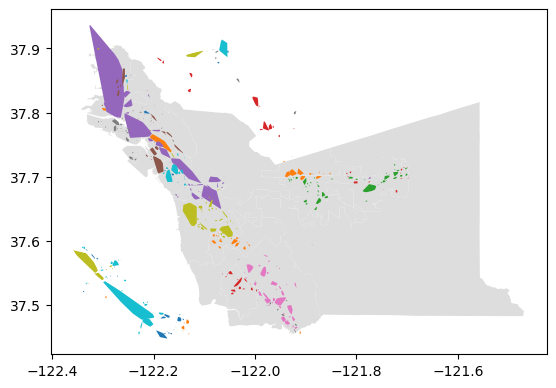

In [24]:
# Check one county's worth

one_county = jurisdictions_2020_clipped.query('county_geoid=="06001"')
minx, miny, maxx, maxy = one_county.total_bounds
ax=spaces_dbscan_hulled_submarkets.cx[minx:maxx, miny:maxy].plot(column='cluster')
one_county.plot(ax=ax,zorder=0,color='#DDDDDD')

Text(0.5, 1.0, 'CoStar point clusters, within a threshold of 150 meters')

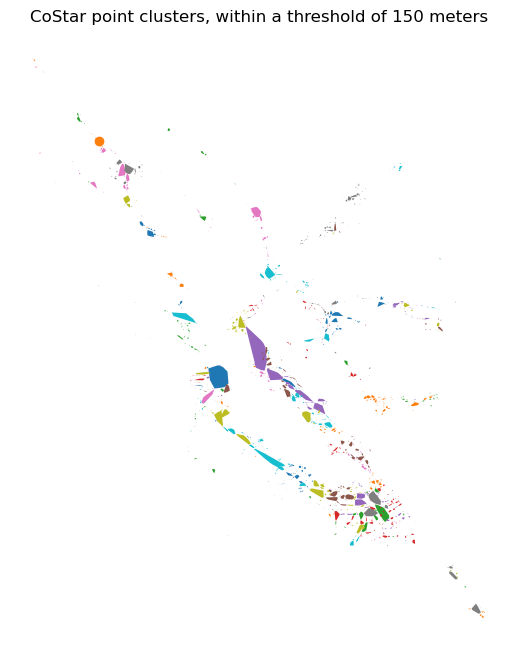

In [25]:
# Meh. The chosen epsilon is super arbitrary, and the hull approach added on leads to messy geometries

ax = spaces_dbscan_hulled_submarkets.plot(column='cluster', figsize=[8, 8])
ax.axis('off')
ax.set_title(f'CoStar point clusters, within a threshold of {epsilon} meters')

## Alternative: Neighborhoods from convex hull

After brief excitement, these are not practical for multi-class data as invariably end up overlapping - so not useful as an approach

<AxesSubplot: >

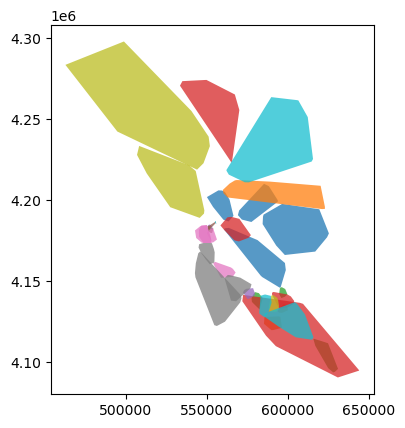

In [26]:
spaces_submarkets = spaces.groupby(['submarket_cluster']).apply(
    lambda x: x.geometry.unary_union.convex_hull)

spaces_submarkets = gpd.GeoSeries(spaces_submarkets, crs='EPSG:4326').to_crs(
    'EPSG:26910').reset_index(name='geometry')

spaces_submarkets.plot(column='submarket_cluster',alpha=.75)


## Alternative: Neighborhoods using voronoi tesellation

Voronois partition point space nicely into separate regions. Kind of like a spatial k-means split.

In [27]:
import geopandas as gpd
from scipy.spatial import Voronoi
from shapely.geometry import Polygon


def generate_voronoi_polys(spaces, yvar, xvar, nbhvar, region_shape):

    # First we extract coordinates as a list of tuples
    coordinates = list(zip(spaces[xvar], spaces[yvar]))

    # Then we generate a basic voronoi diagram - same row index as the coordinates list 
    # and CoStar data
    vor = Voronoi(coordinates)

    # Create a list to store polygons and their associated submarket names
    polygons = []
    submarket_names = []

    # Iterate over Voronoi point_region (same dimensionality as costar spaces df
    # and associate them with submarket names
    
    for point_index, region_index in enumerate(vor.point_region):
        # Get the region vertices
        region = vor.regions[region_index]
        if -1 not in region and len(region) > 0:
            # Extract the vertices for the region
            vertices = [vor.vertices[i] for i in region]
            # Create a shapely Polygon object
            polygon = Polygon(vertices)
            # Assign the submarket name based on the point index
            submarket_name = spaces.iloc[point_index][nbhvar]
            # Append the polygon and submarket name to respective lists
            polygons.append(polygon)
            submarket_names.append(submarket_name)

    # Create a GeoDataFrame from the listed polygons and submarket names
    voronoi_polys = gpd.GeoDataFrame(
        {'geometry': polygons, nbhvar: submarket_names}, crs='EPSG:4326')

    # Dissolve based on nbhvar
    voronoi_polys_dissolved = voronoi_polys.dissolve(by=nbhvar)
    #voronoi_polys_dissolved = gpd.clip(    voronoi_polys_dissolved,region)

    voronoi_polys_dissolved_reg = gpd.overlay(
        voronoi_polys_dissolved.to_crs('EPSG:26910').reset_index(), region_shape)

    # Let's get both a disolved version and a regionalized version
    return voronoi_polys_dissolved, voronoi_polys_dissolved_reg


voronoi_polys_dissolved, voronoi_polys_dissolved_reg = generate_voronoi_polys(
    spaces, 'latitude', 'longitude', 'submarket_name', region_shape)

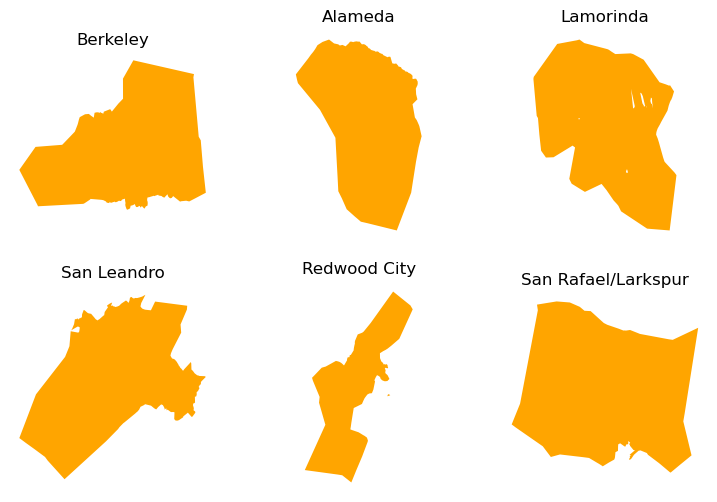

In [28]:
# check out a few submarkets
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=[9, 6], sharey=False)
axs = axs.ravel()
for i, subm in enumerate(['Berkeley', 'Alameda', 'Lamorinda', 'San Leandro', 'Redwood City', 'San Rafael/Larkspur']):
    voronoi_polys_dissolved.loc[[subm]].plot(ax=axs[i], color='orange')
    axs[i].set_title(subm)
    axs[i].axis('off')

In [29]:
voronoi_polys_dissolved.to_file(
    '/Users/aolsen/Downloads/costar_submarkets_voronoi_noclip.geojson', driver='GeoJSON')
voronoi_polys_dissolved_reg.to_file(
    '/Users/aolsen/Downloads/costar_submarkets_voronoi_clip.geojson', driver='GeoJSON')

In [30]:
# # # find outlier points - want to check why the voronoi has triangles out on the east coast
# # but turns out those slivers come from stragglers in the costar data

# from shapely.geometry import Point, LineString

# # get bbx (minx, miny, maxx, maxy)
# bbox = spaces.geometry.total_bounds


# bbox_edges = {
#     'north': LineString([(bbox[0], bbox[3]), (bbox[2], bbox[3])]),
#     'south': LineString([(bbox[0], bbox[1]), (bbox[2], bbox[1])]),
#     'east': LineString([(bbox[2], bbox[1]), (bbox[2], bbox[3])]),
#     'west': LineString([(bbox[0], bbox[1]), (bbox[0], bbox[3])])
# }

# # Find the points closest to each bounding box edge
# closest_to_edges = {}
# for edge, line in bbox_edges.items():
#     closest_point = spaces.distance(line).idxmin()
#     closest_to_edges[edge] = closest_point

# # Extract the four closest points to the edges
# four_closest_points = closest_to_edges
# spaces.loc[four_closest_points.values()].explore(color='red',style_kwds={'radius':4})

### Variant: Voronoi filled with h3 hexagons

This is a good candidate for wall-to-wall coverage - though we don't get any data benefit from the CURRENT costar dataset since by definition all those points are captured by the hexagons generated from that dataset. but the wall to wall would be good for forward-looking, general purpose applications, including getting a map of submarkets we can use with CoStar's time series data.

However - there is a sliver that shoots out to the east and west that makes this rather useless, unless handled separately.

In [31]:
voronoi_hex_9 = generate_h3_within_polys(
    voronoi_polys_dissolved_reg.reset_index(), grps=['submarket_name'], resolution=9)

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/1645050357.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for nme, dta in poly_data.groupby(grps):


<AxesSubplot: >

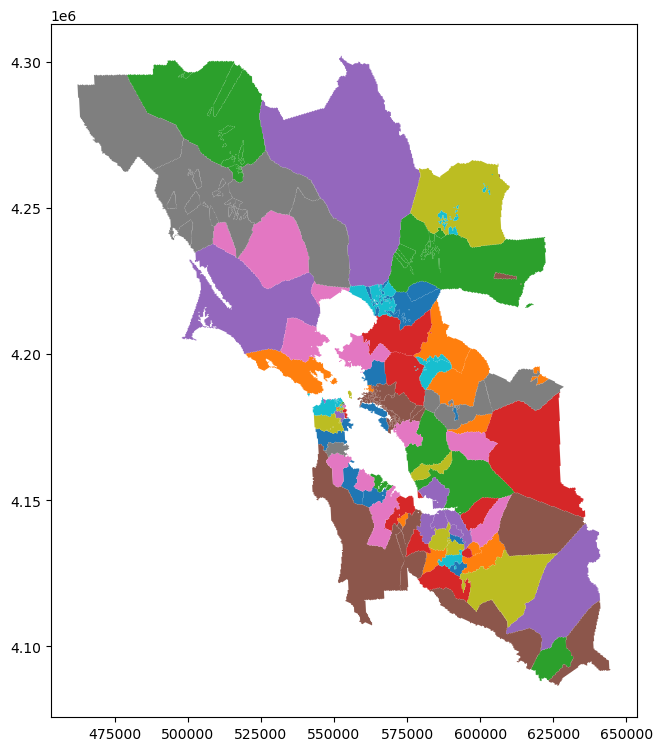

In [32]:
# pretty nice approximation of submarkets

submarkets_from_voronoi_hexed_9 = voronoi_hex_9.dissolve('submarket_name')
submarkets_from_voronoi_hexed_9.reset_index().plot(column='submarket_name',figsize=[9,9])

In [33]:
# fill the voronoi diagram with resultion 8 hexagons 
voronoi_hex_8 = generate_h3_within_polys(
    voronoi_polys_dissolved_reg.reset_index(), grps=['submarket_name'], resolution=8)

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/1645050357.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for nme, dta in poly_data.groupby(grps):


<AxesSubplot: >

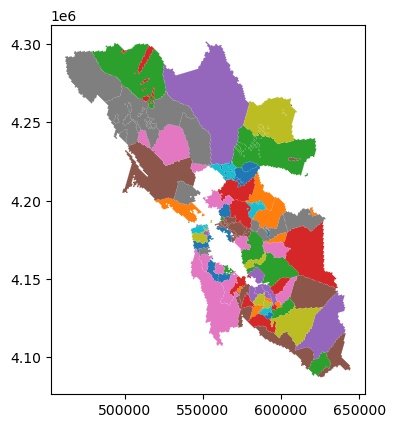

In [34]:
submarkets_from_voronoi_hexed_8 = voronoi_hex_8.dissolve('submarket_name')
submarkets_from_voronoi_hexed_8.reset_index().plot(column='submarket_name')

In [35]:
voronoi_hex_7 = generate_h3_within_polys(
    voronoi_polys_dissolved_reg.reset_index(), grps=['submarket_name'], resolution=7)

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/1645050357.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for nme, dta in poly_data.groupby(grps):


<AxesSubplot: >

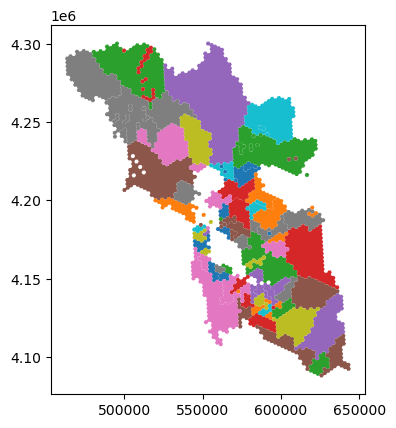

In [36]:
submarkets_from_voronoi_hexed_7 = voronoi_hex_7.dissolve('submarket_name')
submarkets_from_voronoi_hexed_7.reset_index().plot(column='submarket_name')

In [37]:
# voronoi_hex['geometry']=voronoi_hex.h3_polyfill.map(jurisdictions_hex.set_index('h3_polyfill').geometry)
# voronoi_hex = voronoi_hex[voronoi_hex.is_valid].reset_index()
# voronoi_hex_dissolve = voronoi_hex.dissolve('submarket_name')
# voronoi_hex_dissolve.reset_index().explore('submarket_name')

In [38]:
# jurisdictions_hex.query('juris=="Albany"').explore()

In [ ]:
# submarkets_from_voronoi_hexed_9.to_file('/Users/aolsen/Downloads/voronoi_hex_9.geojson',driver='GeoJSON')

# submarkets_from_voronoi_hexed_8.to_file('/Users/aolsen/Downloads/voronoi_hex_8.geojson',driver='GeoJSON')

# submarkets_from_voronoi_hexed_7.to_file('/Users/aolsen/Downloads/voronoi_hex_7.geojson',driver='GeoJSON')

## Using hexbins to regionalize neighborhoods around points

Uber's H3 approach of regionalization is neat and encapsulates the globe. That's just about big enough.

### sjoin approach

In [43]:

# get county geojson
client = create_socrata_client(read_only=True)
county_us_json = client.get('53yx-hhrn', content_type='geojson', **
                            {'select': 'the_geom,name,state,geoid', 'where': "state='California'"})

# make geodataframe
county_us = gpd.GeoDataFrame.from_features(
    county_us_json, crs='EPSG:4326')

# subset to bay area counties
county_bayarea = county_us[county_us.geoid.isin(
    bayareafips_full)].to_crs('EPSG:26910')
county_bayarea = county_bayarea.rename(columns={'name': 'county_name'})
county_bayarea.county_name = county_bayarea.county_name.str.replace(
    ' County', '')

bayarea_hex = h3fy(county_bayarea, resolution=6)



In [44]:
# then, join costar data to the hex bins

spaces_x_bayareahex = gpd.sjoin(spaces.to_crs('EPSG:26910'), bayarea_hex)
spaces_x_bayareahex.head(2)

,oid,source_file,propertyid,property_address,property_name,building_park,propertytype,building_status,building_class,submarket_cluster,...,year_built_cat,juris,county_geoid,jurisdiction_geoid,geometry,property_count,x,y,cluster,index_right
1,76.0,CostarExport(1) pipeline.xlsx,11334590.0,200 Rhode Island St,NaN,NaN,Office,Under Construction,A,SF Downtown South,...,After 2020,San Francisco,06075,0667000,POINT (552559.252 4180145.450),1,552559.252107,4.180145e+06,1,86283082fffffff
2,129.0,CostarExport(1) pipeline.xlsx,10981497.0,8 2nd St,Phase I Parcel A1,Pier 70,Office,Proposed,A,SF Southeast,...,After 2020,San Francisco,06075,0667000,POINT (554249.721 4179389.569),1,554249.720572,4.179390e+06,-1,86283082fffffff


### Points to hex, then aggregate RBA within each hex, assign hex to submarkets using RBA weights

Preferred option - we also use the micro-components - the hexagons - as units for weighing building space within other geographies, such as jurisdictions

In [45]:
spaces_select = spaces[['geometry', 'rba',
                        'property_count', 'latitude', 'longitude']]

In [47]:
# not wall-to-wall coverage, but 


def submarket_to_juris(spaces_df,
                       juris_df,
                       superdistricts_df,
                       h3_resolution,
                       juris_cols=['geometry', 'county', 'juris']):
    """
    Assigns submarkets and jurisdictions to spaces based on H3 hex aggregation and spatial joins.

    Args:
        spaces_df (GeoDataFrame): GeoDataFrame containing spaces data with geometry and relevant columns.
        juris_df (GeoDataFrame): GeoDataFrame containing jurisdiction boundaries and information.
        h3_resolution (int): H3 resolution to use for aggregation.
        juris_columns (list, optional): List of columns to include from the juris GeoDataFrame. Defaults to ["geometry", "county", "juris"].

    Returns:
        GeoDataFrame: A GeoDataFrame with submarket and jurisdiction assignments added.
    """

    # Create hex_name string for convenience
    hex_name = f"h3_{h3_resolution:02d}"

    # Needed columns from the spaces GeoDataFrame
    spaces_columns = ["geometry", "rba",
                      "property_count", "latitude", "longitude"]

    # Aggregate spaces into H3 hexagons and calculate RBA
    spaces_hex_rba = spaces_df[spaces_columns].h3.geo_to_h3_aggregate(
        h3_resolution, return_geometry=True).reset_index()

    spaces_x_spaces_hex_rba = gpd.sjoin(spaces, spaces_hex_rba)

    # get submarket name based on largest share of RBA in submarket
    total_rba_each_hex_submarket = spaces_x_spaces_hex_rba.groupby(
        [hex_name, 'submarket_name']).rba_left.sum()

    largest_submarket_each_hex_by_rba = total_rba_each_hex_submarket.groupby(
        level=[hex_name], group_keys=False).nlargest(1)

    largest_submarket_each_hex_rba_map = largest_submarket_each_hex_by_rba.reset_index(
        1).submarket_name

    # get submarket name based on largest share of property count in submarket

    total_count_each_hex_submarket = spaces_x_spaces_hex_rba.groupby(
        [hex_name, 'submarket_name']).size()

    largest_submarket_each_hex_by_cnt = total_count_each_hex_submarket.groupby(
        level=[hex_name], group_keys=False).nlargest(1)

    largest_submarket_each_hex_cnt_map = largest_submarket_each_hex_by_cnt.reset_index(
        1).submarket_name

    # assign submarkets - using building weights
    spaces_hex_rba['submarket_name_rba'] = spaces_hex_rba[hex_name].map(
        largest_submarket_each_hex_rba_map)

    # assign submarkets - using building counts
    spaces_hex_rba['submarket_name_cnt'] = spaces_hex_rba[hex_name].map(
        largest_submarket_each_hex_cnt_map)

    spaces_hex_rba['geom_pt'] = spaces_hex_rba.representative_point()

    # assign jurisdictions - could clean up all the crs stuff
    spaces_hex_rba_x_juris = gpd.sjoin(
        spaces_hex_rba.set_geometry('geom_pt').to_crs('EPSG:26910'),
        juris_df[juris_cols].to_crs('EPSG:26910')
    )

    # lastly, assign superdistricts
    spaces_hex_rba_x_superd = gpd.sjoin_nearest(
        spaces_hex_rba.set_geometry('geom_pt').to_crs('EPSG:26910'),
        superdistricts.to_crs('EPSG:26910'),
        max_distance=1000,
        distance_col='distance'
    )

    spaces_hex_rba_x_juris['superdistrict'] = spaces_hex_rba_x_juris[hex_name].map(
        spaces_hex_rba_x_superd.set_index(hex_name).superdistr)

    return spaces_hex_rba_x_juris.drop(['geom_pt'], axis=1).set_geometry('geometry')

What this gives us is a finer grained set of building blocks (smaller hexagons) making up the submarket areas. Too big, and the hexagons are not meaningfully contained within jurisdictions and don't map to them well. If hexagons are too small, many will have few point observations associated with them.
* resolution: '6' gives us about 280 points for the costar data
* resolution '7' gives us about 1,000 points for the costar data
* resolution '8' gives us about 3,300 points for the costar data

<AxesSubplot: >

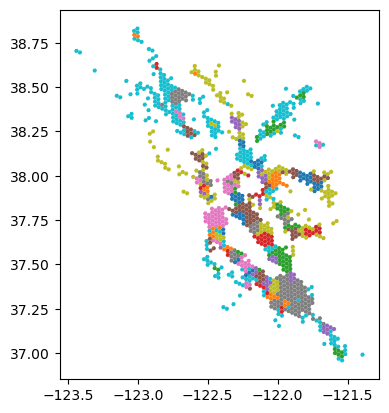

In [48]:
costar_hex_submarkets_res_7 = submarket_to_juris(
    spaces_df=spaces, juris_df=jurisdictions_2020,superdistricts_df=superdistricts,
    h3_resolution=7)
costar_hex_submarkets_res_7.plot(column='juris')

<AxesSubplot: >

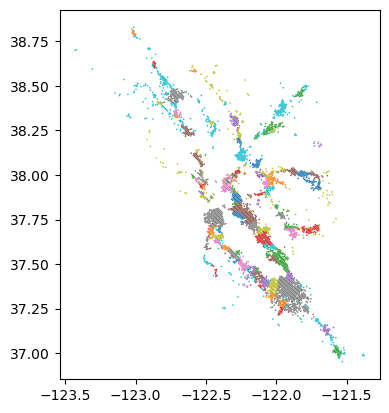

In [49]:
costar_hex_submarkets_res_8 = submarket_to_juris(
    spaces_df=spaces, juris_df=jurisdictions_2020,superdistricts_df=superdistricts,
    h3_resolution=8)
costar_hex_submarkets_res_8.plot(column='juris')

In [50]:
print(costar_hex_submarkets_res_7.head(2))
print(costar_hex_submarkets_res_7.shape)

print(costar_hex_submarkets_res_8.shape)

             h3_07        rba  property_count     latitude    longitude  \
0  872830008ffffff  1444993.0              41  1567.362261 -5012.515397   
1  872830009ffffff  1424305.0              32  1223.859669 -3912.768829   

                                            geometry submarket_name_rba  \
0  POLYGON ((-122.23914 38.22349, -122.23158 38.2...        Napa County   
1  POLYGON ((-122.26440 38.23274, -122.25684 38.2...        Napa County   

  submarket_name_cnt  index_right county                juris  superdistrict  
0        Napa County            2   Napa  Unincorporated Napa           27.0  
1        Napa County            2   Napa  Unincorporated Napa           27.0  
(998, 12)
(3323, 12)


In [51]:
# save the hex maps
costar_hex_submarkets_res_7.to_file('/Users/aolsen/Downloads/costar_submarkets_hex_res_7.geojson',driver='GeoJSON')
costar_hex_submarkets_res_8.to_file('/Users/aolsen/Downloads/costar_submarkets_hex_res_8.geojson',driver='GeoJSON')

In [52]:
#spaces[['propertyid','geometry','property_address','city','submarket_name','rba','latitude','longitude']].to_file('/Users/aolsen/Downloads/costar_submarkets_records.geojson',driver='GeoJSON')

### Get a mappings of submarket to jurisdiction and superdistrict
Now we have the hexagon building blocks, with a numeric attribute such as RBA / building space. We can use that as weights.

In [53]:
pd.options.display.float_format = '{:,.2f}'.format


def costar_submarket_to_target_geo_map(costar_hex_submarkets, target_col='juris'):
    costar_hex_submarkets_pct_in_juris = costar_hex_submarkets.groupby(
        ['submarket_name_rba', target_col]).rba.sum().groupby(['submarket_name_rba']).apply(pct)
    costar_hex_submarkets_pct_in_juris_top = costar_hex_submarkets_pct_in_juris.groupby(
        ['submarket_name_rba'], group_keys=False).nlargest(1)
    costar_hex_submarkets_top_juris_map = costar_hex_submarkets_pct_in_juris_top.reset_index(
        1)[target_col]  # .reset_index(0,drop=True)
    return costar_hex_submarkets_top_juris_map

In [54]:
# get mapping of costar submarkets to jurisdictions
# hese are weighted by built space, so if a submarket is split between cities
# we will get the one with most space in a submart

costar_hex_submarkets_top_juris_map = costar_submarket_to_target_geo_map(
    costar_hex_submarkets_res_8, target_col='juris')

costar_hex_submarkets_top_juris_map.head()

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/1444414593.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ['submarket_name_rba', target_col]).rba.sum().groupby(['submarket_name_rba']).apply(pct)


submarket_name_rba
Alameda                        Alameda
Antioch/Pittsburg              Antioch
Bayview/Hunters Point    San Francisco
Belmont/San Carlos          San Carlos
Benicia                        Benicia
Name: juris, dtype: object

In [55]:
# same thing, but relating submarkets to superdistricts
costar_hex_submarkets_top_sd_map = costar_submarket_to_target_geo_map(costar_hex_submarkets_res_8,
                                                                      target_col='superdistrict').astype(int)

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/1444414593.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ['submarket_name_rba', target_col]).rba.sum().groupby(['submarket_name_rba']).apply(pct)


In [56]:
costar_hex_submarkets_top_sd_map.head()

submarket_name_rba
Alameda                  18
Antioch/Pittsburg        24
Bayview/Hunters Point     3
Belmont/San Carlos        7
Benicia                  25
Name: superdistrict, dtype: int64

# Office vacancy

That was the classification exercise. Now we have submarkets mapped to jurisdictions and superdistricts. Then we can load the vacancy data and relate that to jurisdictions and superdistricts.

In [57]:
# relevant sqft numericals
sf_vals = ['inventory_sf', 'vacant_available_sf']

def round_breakpoints(min_val, max_val, interval):
    # Calculate the number of breakpoints
    num_breakpoints = int((max_val - min_val) / interval) + 1

    # Generate the rounded breakpoints within the specified range
    breakpoints = [min_val + i * interval for i in range(num_breakpoints)]

    return breakpoints



def process_office_vacancy_by_period(data, period):
    office_vacancy_period = data.query(f'period == "{period}"')

    office_vacancy_period['juris'] = office_vacancy_period.submarket_name.map(
        costar_hex_submarkets_top_juris_map)

    office_vacancy_period['county'] = office_vacancy_period.submarket_name.map(
        costar_hex_submarkets_top_juris_map).map(
        jurisdictions_2020.set_index('juris').county)

    office_vacancy_period['superdistrict'] = office_vacancy_period.submarket_name.map(
        costar_hex_submarkets_top_sd_map)

    office_vacancy_period['geometry'] = office_vacancy_period.submarket_name.map(
        costar_hex_submarkets_res_8.dissolve('submarket_name_rba').geometry)

    office_vacancy_period = office_vacancy_period.set_geometry('geometry')

    office_vacancy_period = office_vacancy_period[office_vacancy_period.geometry.is_valid]

    return office_vacancy_period

## Load / process vacancy data

In [58]:
# load vacancy time series data

office_vacancy_path = f'/Users/{user}/Box/DataViz Projects/Data Services/CoStar/Extracts/20230822/vacancy_stats/quarterly/DataExport_DetailLevel_Office_20240109.xlsx'
office_vacancy = pd.read_excel(
    office_vacancy_path)

# clean columnn names
office_vacancy.columns = office_vacancy.columns.str.replace(
    ' ', '_').str.replace('[/\%]', '').str.replace('/', '_per_').str.lower()

# subset to submarkets
office_vacancy = office_vacancy[office_vacancy.geography_type ==
                                'Submarket']

# deal with time periods to skip
period_drop = ['2023 Q3', '2023 Q4', '2024 Q4',
               '2025 Q4', '2026 Q4', '2027 Q4', '2028 Q4', '2029 Q4', '2030 Q4', '2031 Q4', '2032 Q4',
               '2033 Q3']
office_vacancy = office_vacancy.loc[~office_vacancy.period.isin(period_drop)]

# get year
office_vacancy['year'] = office_vacancy.period.str.extract(
    '(\d{4})', expand=False).astype(int)

# note submarkets are embedded in a geography_name string with cbsa deets
print(office_vacancy.geography_name.sample(5))

# split out the submarket string and keep components - msa and submarket_name
office_vacancy_submarket_detail = office_vacancy.geography_name.str.split(
    ' - CA (USA) - ', regex=False).apply(pd.Series, index=['msa', 'submarket_name'])
office_vacancy_submarket_detail


# join these details back to the original dataframe
office_vacancy = office_vacancy.join(office_vacancy_submarket_detail)
office_vacancy.submarket_name = office_vacancy.submarket_name.str.strip()

# add county from the just added submarket_name string
office_vacancy['county'] = office_vacancy.submarket_name.map(
        costar_hex_submarkets_top_juris_map).map(
        jurisdictions_2020.set_index('juris').county)


# keep q1 data only - we relate to employment data later, also for q1
office_vacancy = office_vacancy[office_vacancy.period.str.contains('Q1$')]

office_vacancy.head()

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/3668878066.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  ' ', '_').str.replace('[/\%]', '').str.replace('/', '_per_').str.lower()


3163                    East Bay - CA (USA) - San Ramon
1942    East Bay - CA (USA) - Martinez/Pacheco/Hercules
544             East Bay - CA (USA) - Antioch/Pittsburg
953         East Bay - CA (USA) - Concord/Pleasant Hill
2804                   East Bay - CA (USA) - Pleasanton
Name: geography_name, dtype: object


,property_class_name,period,slice,as_of,geography_name,property_type,geography_code,forecast_scenario,cbsa_code,geography_type,...,transaction_sale_pricesf,under_construction_buildings,under_construction_sf,vacancy_rate,vacant_available_,vacant_available_sf,year,msa,submarket_name,county
384,Office,1997 Q1,All,2024 Q1,East Bay - CA (USA) - Alameda,Office,G32553,Base Case,36084,Submarket,...,NaN,5,"274,002.00",0.09,0.09,"307,405.00",1997,East Bay,Alameda,Alameda
388,Office,1998 Q1,All,2024 Q1,East Bay - CA (USA) - Alameda,Office,G32553,Base Case,36084,Submarket,...,NaN,0,NaN,0.08,0.08,"308,659.00",1998,East Bay,Alameda,Alameda
392,Office,1999 Q1,All,2024 Q1,East Bay - CA (USA) - Alameda,Office,G32553,Base Case,36084,Submarket,...,87.99,2,"134,606.00",0.06,0.06,"210,733.00",1999,East Bay,Alameda,Alameda
396,Office,2000 Q1,All,2024 Q1,East Bay - CA (USA) - Alameda,Office,G32553,Base Case,36084,Submarket,...,143.25,1,"77,130.00",0.04,0.04,"158,374.00",2000,East Bay,Alameda,Alameda
400,Office,2001 Q1,All,2024 Q1,East Bay - CA (USA) - Alameda,Office,G32553,Base Case,36084,Submarket,...,NaN,2,"126,655.00",0.04,0.04,"170,004.00",2001,East Bay,Alameda,Alameda


In [59]:

#office_vacancy.to_csv('/Volumes/Data/Models/urban_modeling/data/realestate/costar_office_vacancy_timeseries_jan2024.csv')
office_vacancy.groupby(['year','period','county']).sum()

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/3327208375.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  office_vacancy.groupby(['year','period','county']).sum()


cbsa_code       asset_value  availability_rate  \
year period  county                                                          
1997 1997 Q1 Alameda           541260              0.00               0.00   
             Contra Costa      360840              0.00               0.00   
             San Francisco     712028              0.00               0.00   
             San Mateo         418840              0.00               0.00   
             Santa Clara       964620              0.00               0.00   
...                               ...               ...                ...   
2023 2023 Q1 San Francisco     712028 84,019,542,352.00               3.73   
             San Mateo         418840 38,694,677,888.00               1.23   
             Santa Clara       964620 94,860,435,308.00               3.03   
             Solano            186800  1,776,168,068.00               0.27   
             Sonoma            211100  4,046,715,232.00               0.46   

                            availability_rate__direct  \
year period  county                                     
1997 1997 Q1 Alameda                             0.00   
             Contra Costa                        0.00   
             San Francisco                       0.00   
             San Mateo                           0.00   
             Santa Clara                         0.00   
...                                               ...   
2023 2023 Q1 San Francisco                       2.73   
             San Mateo                           0.96   
             Santa Clara                         2.37   
             Solano                              0.26   
             Sonoma                              0.42   

                            availability_rate__sublet  available_sf_direct  \
year period  county                                                          
1997 1997 Q1 Alameda                             0.00                 0.00   
             Contra Costa                        0.00                 0.00   
             San Francisco                       0.00                 0.00   
             San Mateo                           0.00                 0.00   
             Santa Clara                         0.00                 0.00   
...                                               ...                  ...   
2023 2023 Q1 San Francisco                       1.05        25,663,447.00   
             San Mateo                           0.32         6,202,380.00   
             Santa Clara                         0.69        18,734,853.00   
             Solano                              0.01           708,102.00   
             Sonoma                              0.03         1,577,955.00   

                            available_sf_sublet  available_sf_total  \
year period  county                                                   
1997 1997 Q1 Alameda                       0.00                0.00   
             Contra Costa                  0.00                0.00   
             San Francisco                 0.00                0.00   
             San Mateo                     0.00                0.00   
             Santa Clara                   0.00                0.00   
...                                         ...                 ...   
2023 2023 Q1 San Francisco         9,681,026.00       35,020,162.00   
             San Mateo             2,409,601.00        8,386,792.00   
             Santa Clara           5,809,796.00       24,135,412.00   
             Solano                   31,997.00          740,099.00   
             Sonoma                  130,416.00        1,708,371.00   

                            average_sale_price  cap_rate  ...  \
year period  county                                       ...   
1997 1997 Q1 Alameda              8,936,333.00      0.48  ...   
             Contra Costa         2,190,750.00      0.13  ...   
             San Francisco       48,593,900.00      0.26  ...   
       

In [60]:
# grab time specific slices

office_vacancy_2023q1 = process_office_vacancy_by_period(
    office_vacancy, '2023 Q1')

office_vacancy_2019q1 = process_office_vacancy_by_period(
    office_vacancy, '2019 Q1')

office_vacancy_2015q1 = process_office_vacancy_by_period(
    office_vacancy, '2015 Q1')

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/527651120.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  office_vacancy_period['juris'] = office_vacancy_period.submarket_name.map(
/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/527651120.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  office_vacancy_period['county'] = office_vacancy_period.submarket_name.map(
/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/527651120.py:25: SettingWithCopyWarning:

In [61]:
before_quarter = '2019 Q1'
#before_quarter = '2015 Q1'
after_quarter = '2023 Q1'

# basic difference
office_vacancy_diff_before_after = office_vacancy.set_index(['period', 'msa', 'submarket_name']).vacancy_rate.loc[[
    before_quarter, after_quarter]].unstack(0).diff(axis=1)[after_quarter].reset_index()

# add geometry
office_vacancy_diff_before_after['geometry'] = office_vacancy_diff_before_after.submarket_name.map(
    costar_hex_submarkets_res_8.dissolve('submarket_name_rba').geometry)

office_vacancy_diff_before_after = office_vacancy_diff_before_after.set_geometry(
    'geometry')
office_vacancy_diff_before_after = office_vacancy_diff_before_after[
    office_vacancy_diff_before_after.is_valid]
office_vacancy_diff_before_after

,msa,submarket_name,2023 Q1,geometry
0,East Bay,Alameda,-0.05,"MULTIPOLYGON (((-122.28335 37.76933, -122.2892..."
1,East Bay,Antioch/Pittsburg,0.02,"MULTIPOLYGON (((-121.88980 37.99684, -121.8943..."
2,East Bay,Berkeley,0.04,"POLYGON ((-122.29155 37.85036, -122.29748 37.8..."
3,East Bay,Bishop Ranch,0.05,"POLYGON ((-121.95079 37.75701, -121.95529 37.7..."
4,East Bay,Concord/Pleasant Hill,0.01,"MULTIPOLYGON (((-122.08716 37.92963, -122.0886..."
...,...,...,...,...
86,Santa Rosa,Sonoma/Wine Country,0.03,"MULTIPOLYGON (((-122.47884 38.23859, -122.4833..."
87,Vallejo-Fairfield,Benicia/Vallejo,-0.02,"MULTIPOLYGON (((-122.16171 38.06322, -122.1557..."
88,Vallejo-Fairfield,Fairfield/Suisun City,0.02,"MULTIPOLYGON (((-122.14967 38.22384, -122.1437..."
89,Vallejo-Fairfield,Outer Solano County,0.00,"POLYGON ((-121.73073 38.17296, -121.72619 38.1..."


/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/3818608652.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax = office_vacancy.groupby(['year', 'county']).sum().filter(


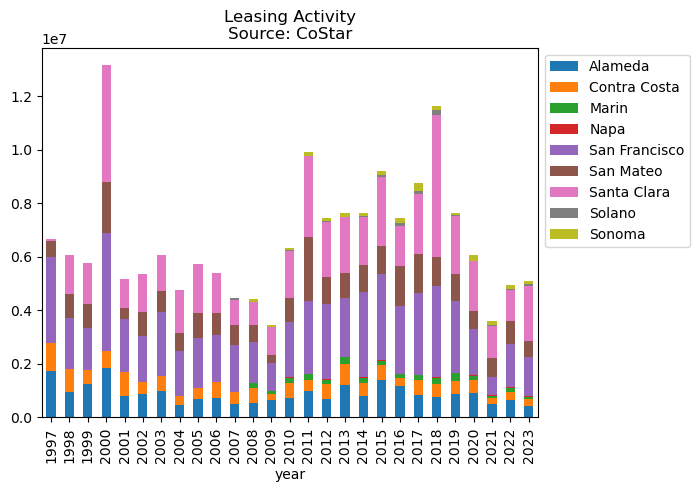

In [62]:
ax = office_vacancy.groupby(['year', 'county']).sum().filter(
    regex='leas').leasing_sf_total.unstack(1).plot(kind='bar', stacked=True)
ax.set_title('Leasing Activity\nSource: CoStar')
ax.legend(loc=2, bbox_to_anchor=(1, 1))

In [63]:
office_inventory_by_county = office_vacancy.groupby(['year','county'])[sf_vals].sum()

# note we are grabbing just INVENTORY here, not OCCUPIED inventory

# numerator_space = office_inventory_by_county.inventory_sf.loc[[
#     2019, 2022]].unstack(0)

# fixed, Jan 2024
office_inventory_by_county['occupied_sf'] = office_inventory_by_county.inventory_sf - \
    office_inventory_by_county.vacant_available_sf

In [64]:
numerator_space = office_inventory_by_county.occupied_sf.loc[[
    2015, 2019, 2023]].unstack(0)
office_inventory_by_county

inventory_sf  vacant_available_sf    occupied_sf
year county                                                         
1997 Alameda            58700078         3,357,459.00  55,342,619.00
     Contra Costa       34275926         1,408,817.00  32,867,109.00
     San Francisco     111304088         4,067,068.00 107,237,020.00
     San Mateo          33119786         1,034,421.00  32,085,365.00
     Santa Clara        78324974         2,215,672.00  76,109,302.00
...                          ...                  ...            ...
2023 San Francisco     128008722        23,968,215.00 104,040,507.00
     San Mateo          58686133         5,496,764.00  53,189,369.00
     Santa Clara       141408292        16,039,955.00 125,368,337.00
     Solano              8430598           504,636.00   7,925,962.00
     Sonoma             17186379         1,490,914.00  15,695,465.00

[203 rows x 3 columns]

In [65]:
#office_inventory_by_county = office_inventory_by_county.sum(level=[1,2])
office_inventory_by_county_2019_2022 = office_inventory_by_county.loc[[2019,2023]]
office_inventory_by_county_2019_2022['vacancy_rate'] = office_inventory_by_county_2019_2022.vacant_available_sf / office_inventory_by_county_2019_2022.inventory_sf
office_inventory_by_county_2019_2022.vacancy_rate.unstack(0).diff(axis=1)[2023]
office_inventory_by_county_2019_2022.unstack(0)

inventory_sf            vacant_available_sf                \
year                  2019       2023                2019          2023   
county                                                                    
Alameda           72851100   74946602        4,267,565.00  8,213,167.00   
Contra Costa      39366487   38756012        3,485,613.00  5,035,403.00   
Marin             12692236   12746516        1,689,465.00  1,678,133.00   
Napa               3511161    3515662          121,305.00    250,829.00   
San Francisco    123502062  128008722        4,062,530.00 23,968,215.00   
San Mateo         53606291   58686133        3,568,698.00  5,496,764.00   
Santa Clara      131514236  141408292       10,135,378.00 16,039,955.00   
Solano             8439279    8430598          828,446.00    504,636.00   
Sonoma            17199269   17186379          731,791.00  1,490,914.00   

                 occupied_sf                vacancy_rate       
year                    2019           2023         2019 2023  
county                                                         
Alameda        68,583,535.00  66,733,435.00         0.06 0.11  
Contra Costa   35,880,874.00  33,720,609.00         0.09 0.13  
Marin          11,002,771.00  11,068,383.00         0.13 0.13  
Napa            3,389,856.00   3,264,833.00         0.03 0.07  
San Francisco 119,439,532.00 104,040,507.00         0.03 0.19  
San Mateo      50,037,593.00  53,189,369.00         0.07 0.09  
Santa Clara   121,378,858.00 125,368,337.00         0.08 0.11  
Solano          7,610,833.00   7,925,962.00         0.10 0.06  
Sonoma         16,467,478.00  15,695,465.00         0.04 0.09

In [66]:
# get difference 2019-2023 as a series
office_vacancy_diff = office_vacancy_diff_before_after.set_index(['msa','submarket_name'])[after_quarter].sort_values()
office_vacancy_diff_sort_order = office_vacancy_diff.index.get_level_values(1)

office_vacancy_diff

msa            submarket_name         
San Jose       North San Jose            -0.05
East Bay       Alameda                   -0.05
San Francisco  Burlingame                -0.05
East Bay       San Leandro               -0.03
San Jose       Gilroy                    -0.03
                                          ... 
San Francisco  Financial District         0.18
               Showplace Square           0.20
               South of Market            0.21
               Mission Bay/China Basin    0.26
               Yerba Buena                0.37
Name: 2023 Q1, Length: 88, dtype: float64

### Side-by-side before-after vacancy maps by costar submarket

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/89107402.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


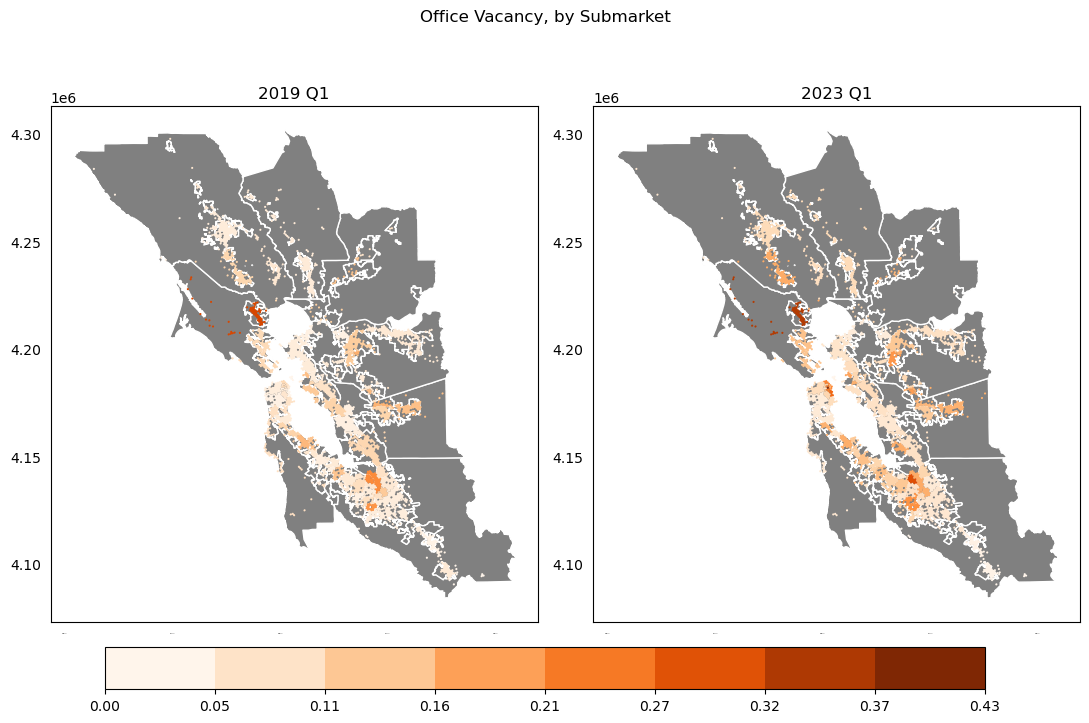

In [68]:


def plot_office_vacancy(jurisdictions_2020_clipped, office_vacancy_2019q1, office_vacancy_2023q1):
    fig, axs = plt.subplots(ncols=2, figsize=[11, 8.5])

    # Plotting maps on subplots
    for ax in axs:
        ax.tick_params(axis='both', which='both', bottom=False,
                       top=False, left=False, right=False)
        # To remove the x-axis labels
        ax.tick_params(axis='x', which='both', labelsize=0)

    # Plotting the maps
    im1 = jurisdictions_2020_clipped.to_crs('EPSG:26910').plot(
        edgecolor='white', color='grey', ax=axs[0])
    im2 = jurisdictions_2020_clipped.to_crs('EPSG:26910').plot(
        edgecolor='white', color='grey', ax=axs[1])

    # Plotting the vacancy rates
    cmap = cm.Oranges
    data_min = min(office_vacancy_2019q1['vacancy_rate'].min(
    ), office_vacancy_2023q1['vacancy_rate'].min())
    data_max = max(office_vacancy_2019q1['vacancy_rate'].max(
    ), office_vacancy_2023q1['vacancy_rate'].max())

    num_bins = 8  # Set the number of bins for both map and colorbar

    # Define levels for the colorbar
    levels = [data_min + (data_max - data_min) * i /
              num_bins for i in range(num_bins + 1)]

    # Create a colormap and norm instance
    norm = BoundaryNorm(levels, cmap.N)

    # Plotting the vacancy rates with the same colorbar as defined
    office_vacancy_2019q1.to_crs('EPSG:26910').plot(
        column='vacancy_rate', cmap=cmap, ax=axs[0], legend=False, vmin=data_min, vmax=data_max)
    office_vacancy_2023q1.to_crs('EPSG:26910').plot(
        column='vacancy_rate', cmap=cmap, ax=axs[1], legend=False, vmin=data_min, vmax=data_max)

    # Create a colorbar for the entire figure
    cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.05])  # [left, bottom, width, height]
    cbar = ColorbarBase(cbaxes, cmap=cmap, norm=norm, orientation='horizontal')
    cbar.set_ticks(levels)
    cbar.ax.set_xticklabels([f'{level:.2f}' for level in levels])

    # Add titles
    axs[0].set_title('2019 Q1')
    axs[1].set_title('2023 Q1')
    fig.suptitle('Office Vacancy, by Submarket', y=.9)

    plt.tight_layout()
    plt.show()

plot_office_vacancy(jurisdictions_2020_clipped, office_vacancy_2019q1, office_vacancy_2023q1)


/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/1212671502.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


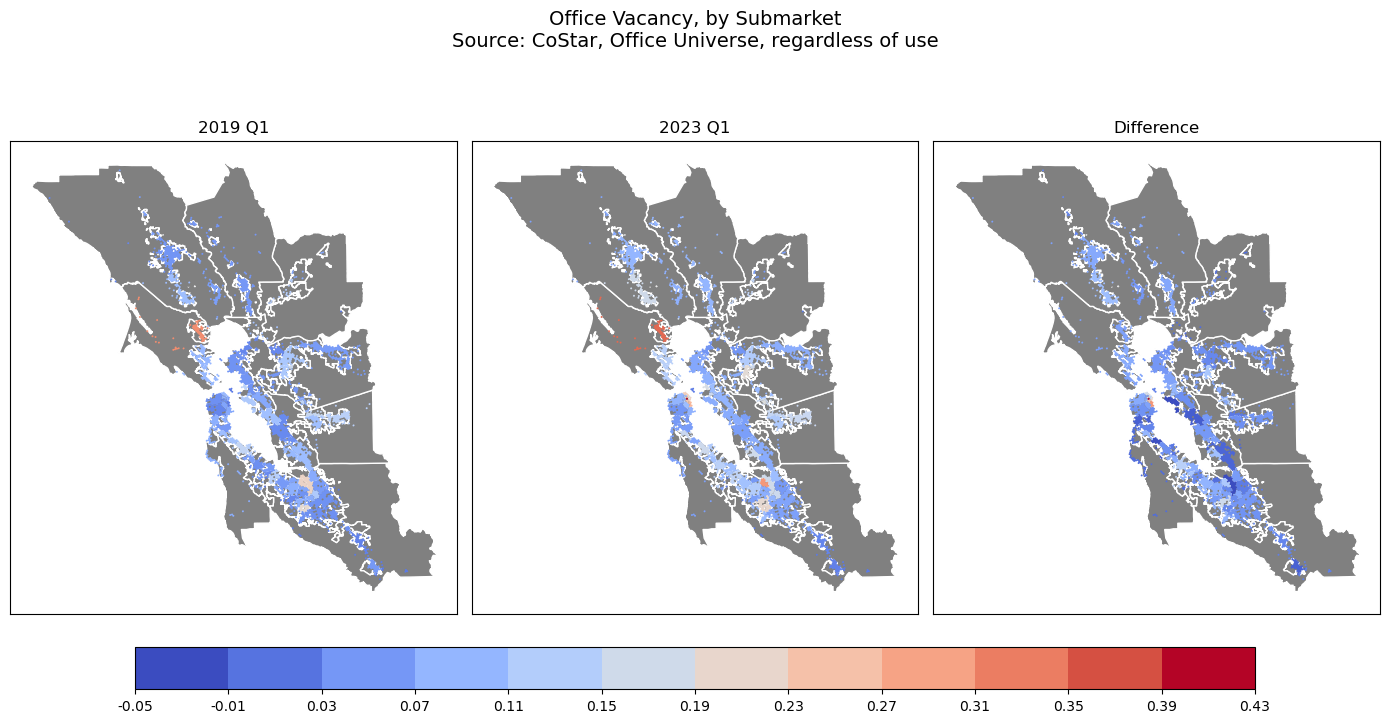

In [69]:
def round_breakpoints(min_val, max_val, step):
    return [round(min_val + step * i, 2) for i in range(int((max_val - min_val) / step) + 2)]


def plot_office_vacancy_comparison(jurisdictions_2020_clipped, office_vacancy_2019q1, office_vacancy_2023q1, office_vacancy_diff_before_after):
    fig, axs = plt.subplots(ncols=3, figsize=[14, 8.5])

    # Plotting maps on subplots
    for ax in axs:
        ax.tick_params(axis='both', which='both', bottom=False,
                       top=False, left=False, right=False)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    # Plotting the maps - silly to to the to_crs repeatedly
    im1 = jurisdictions_2020_clipped.to_crs('EPSG:26910').plot(
        edgecolor='white', color='grey', ax=axs[0])
    im2 = jurisdictions_2020_clipped.to_crs('EPSG:26910').plot(
        edgecolor='white', color='grey', ax=axs[1])
    im3 = jurisdictions_2020_clipped.to_crs('EPSG:26910').plot(
        edgecolor='white', color='grey', ax=axs[2])

    # Plotting the vacancy rates - should pull out the '2023 Q1 hardcoding for flexibility'
    cmap = cm.coolwarm
    data_min = min(office_vacancy_2019q1['vacancy_rate'].min(
    ), office_vacancy_2023q1['vacancy_rate'].min(), office_vacancy_diff_before_after['2023 Q1'].min())
    data_max = max(office_vacancy_2019q1['vacancy_rate'].max(
    ), office_vacancy_2023q1['vacancy_rate'].max(), office_vacancy_diff_before_after['2023 Q1'].max())

    num_bins = 8  # Set the number of bins for both map and colorbar

    # Define levels for the colorbar
    levels = round_breakpoints(data_min, data_max, .04)

    # Create a colormap and norm instance
    cmap = cm.coolwarm
    norm = BoundaryNorm(levels, cmap.N)

    # Plotting the vacancy rates with the same colorbar as defined
    office_vacancy_2019q1.to_crs('EPSG:26910').plot(
        column='vacancy_rate', cmap=cmap, ax=axs[0], legend=False, vmin=data_min, vmax=data_max)
    office_vacancy_2023q1.to_crs('EPSG:26910').plot(
        column='vacancy_rate', cmap=cmap, ax=axs[1], legend=False, vmin=data_min, vmax=data_max)

    office_vacancy_diff_before_after.to_crs('EPSG:26910').plot(
        column='2023 Q1', cmap=cmap, ax=axs[2], legend=False)

    # Create a colorbar for the entire figure
    # [left, bottom, width, height]
    cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.05])
    cbar = ColorbarBase(cbaxes, cmap=cmap, norm=norm, orientation='horizontal')
    cbar.set_ticks(levels)
    cbar.ax.set_xticklabels([f'{level:.2f}' for level in levels])

    # Add titles - todo- hardcoding is bad
    axs[0].set_title('2019 Q1')
    axs[1].set_title('2023 Q1')
    axs[2].set_title('Difference')
    fig.suptitle(
        'Office Vacancy, by Submarket\nSource: CoStar, Office Universe, regardless of use', y=.9, size=14)

    plt.tight_layout()
    plt.show()


plot_office_vacancy_comparison(jurisdictions_2020_clipped, office_vacancy_2019q1,
                               office_vacancy_2023q1, office_vacancy_diff_before_after)

<AxesSubplot: ylabel='submarket_name'>

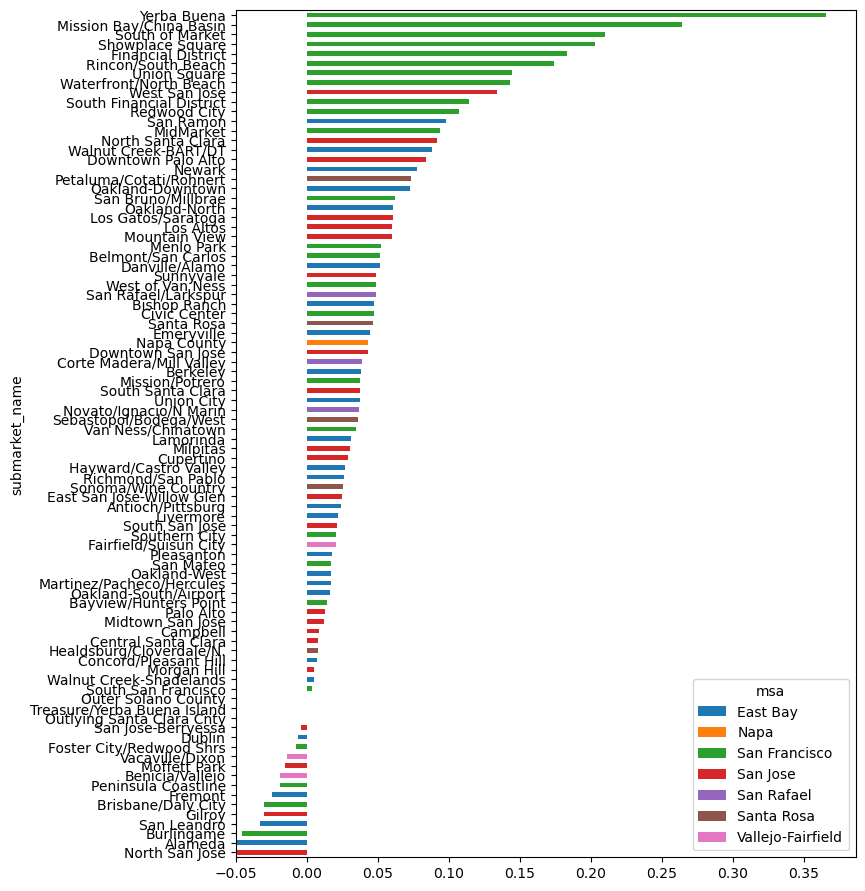

In [70]:
office_vacancy_diff.unstack(0).fillna(0).loc[office_vacancy_diff_sort_order].plot(kind='barh',stacked=True,figsize=[8,11])

### Roll up vacancy to jurisdiction, MSA

In [71]:
# convenience function for weighted vacancy for data in a group 
weighted_vacancy = lambda x: (x.inventory_sf * x.vacancy_rate).sum()/x.inventory_sf.sum()

In [72]:
# weighted msa vacancy 2023 
office_vacancy_2023_q1_msa = office_vacancy_2023q1.groupby(
    ['msa']).apply(weighted_vacancy)

# weighted msa vacancy 2019
office_vacancy_2019_q1_msa = office_vacancy_2019q1.groupby(
    ['msa']).apply(weighted_vacancy)

In [73]:
# weighted juris vacancy 2023
office_vacancy_2023_q1_juris = office_vacancy_2023q1.groupby(
    ['juris']).apply(weighted_vacancy)

# weighted juris vacancy 2019
office_vacancy_2019_q1_juris = office_vacancy_2019q1.groupby(
    ['juris']).apply(weighted_vacancy)

# Jobs and Vacancy relationship - county level

## Jobs counts, by workplace geo

In [83]:
# this is harvested separetely 
place_multi_year = pd.read_csv(
    '/Users/aolsen/Box/Modeling and Surveys/Census/processed/B08501_acs1_jobs_multiyear_place.csv', dtype={'stplace': str}, index_col=0)
place_multi_year = place_multi_year.rename(
    columns={'2019': 'jobs_2019', "2021": 'jobs_2021', "2022": 'jobs_2022'})

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/3088163604.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  place_multi_year.query('level_2!="Estimate!!Total:!!Worked from home:"').groupby(['juris']).sum().plot(kind='bar')


Text(0.5, 1.0, 'Place of work jobs, excluding WFH counts\nSource: ACS 1-year data, 2019, 2021, 2022, B08501')

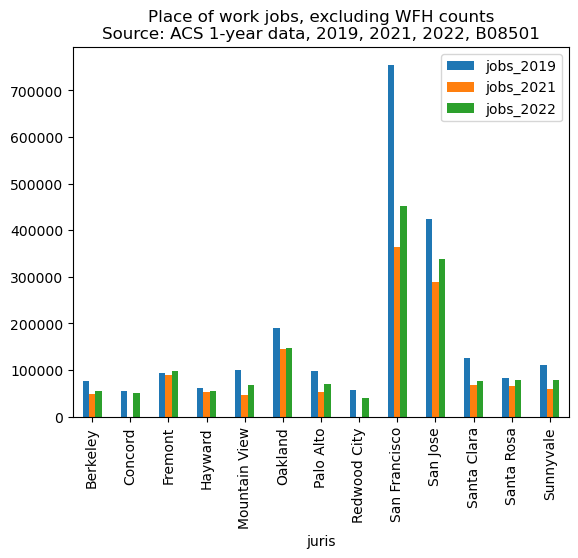

In [84]:
place_multi_year.query('level_2!="Estimate!!Total:!!Worked from home:"').groupby(['juris']).sum().plot(kind='bar')
plt.title('Place of work jobs, excluding WFH counts\nSource: ACS 1-year data, 2019, 2021, 2022, B08501')

In [85]:
place_multi_year.query('juris=="San Francisco" & level_2!="Estimate!!Total:!!Worked from home:"').groupby(['juris']).sum()

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/3464397255.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  place_multi_year.query('juris=="San Francisco" & level_2!="Estimate!!Total:!!Worked from home:"').groupby(['juris']).sum()


,jobs_2019,jobs_2021,jobs_2022
juris,,,
San Francisco,"755,390.00","363,870.00","451,863.00"


In [86]:
## Work from home shares

place_multi_year_wfh = pd.read_csv(
    '/Users/aolsen/Box/Modeling and Surveys/Census/processed/B08501_acs1_wfh_pct_multiyear_place.csv', dtype={'stplace': str}, index_col=0)
place_multi_year_wfh = place_multi_year_wfh.rename(
    columns={'2019': 'wfh_2019', "2021": 'wfh_2021', "2022": 'wfh_2022'})
place_multi_year_wfh

county_multi_year_wfh = pd.read_csv('/Users/aolsen/Box/Modeling and Surveys/Census/processed/B08501_acs1_multiyear_county.csv',dtype={'stcounty':str},index_col=0)
county_multi_year_wfh = county_multi_year_wfh.rename(columns={'2019':'wfh_2019',"2021":'wfh_2021',"2022":'wfh_2022'})
county_multi_year_wfh= county_multi_year_wfh[county_multi_year_wfh.stcounty.isin(bayareafips_full)]
county_multi_year_wfh

,NAME,stcounty,level_2,wfh_2019,wfh_2021,wfh_2022
0,"Alameda County, California",06001,Estimate!!Total:!!Worked from home:,0.07,0.34,0.28
2,"Contra Costa County, California",06013,Estimate!!Total:!!Worked from home:,0.09,0.34,0.25
8,"Marin County, California",06041,Estimate!!Total:!!Worked from home:,0.14,0.32,0.31
11,"Napa County, California",06055,Estimate!!Total:!!Worked from home:,0.05,0.17,0.10
18,"San Francisco County, California",06075,Estimate!!Total:!!Worked from home:,0.05,0.35,0.25
21,"San Mateo County, California",06081,Estimate!!Total:!!Worked from home:,0.06,0.31,0.23
23,"Santa Clara County, California",06085,Estimate!!Total:!!Worked from home:,0.04,0.32,0.22
26,"Solano County, California",06095,Estimate!!Total:!!Worked from home:,0.07,0.16,0.16
27,"Sonoma County, California",06097,Estimate!!Total:!!Worked from home:,0.09,0.22,0.15


In [88]:
place_multi_year_wfh['vac_2019'] = place_multi_year_wfh.juris.map(
    office_vacancy_2019_q1_juris)
# place_multi_year_wfh['vac_2021'] = place_multi_year_wfh.juris.map(
#     office_vacancy_2021_q4_juris)
place_multi_year_wfh['vac_2022'] = place_multi_year_wfh.juris.map(
    office_vacancy_2023_q1_juris)

In [89]:
place_multi_year_wfh_long = place_multi_year_wfh.set_index('juris').filter(regex='\d{4}').stack().reset_index(name='value')
place_multi_year_wfh_long['year'] = place_multi_year_wfh_long.level_1.str.extract('(\d{4})',expand=False).astype(int)
place_multi_year_wfh_long['variable'] = place_multi_year_wfh_long.level_1.str.extract('(wfh|vac)',expand=False)

In [96]:
place_multi_year_wfh_long_s = place_multi_year_wfh_long.query('year.isin([2019,2022])').set_index(['juris','year','variable']).value
place_multi_year_wfh_long_s.head()

# place_multi_year_wfh_long_s.unstack('variable').groupby(level=['year']).apply(lambda x: np.correlate(x.vac,x.wfh)[0])

juris     year  variable
Berkeley  2019  wfh        0.09
          2022  wfh        0.28
          2019  vac        0.03
          2022  vac        0.07
Concord   2019  wfh        0.07
Name: value, dtype: float64

In [97]:
def get_regression_equation(results, X):
    coefficients = results.params
    intercept = coefficients[0]
    other_coeffs = coefficients[1:]
    variable_names = list(X.columns)

    equation = f"y = {intercept:.3f}"

    for i, coeff in enumerate(other_coeffs):
        equation += f" + {coeff:.3f} * {variable_names[i+1]}"

    rsquared = f'{results.rsquared:.02f}'
    return f'{equation} - ($R^2$: {rsquared})'


def annotate_regression_equation(ax, results, X):
    equation = get_regression_equation(results, X)

    ax.text(0.5, 0.9, f"{equation}",
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes,
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


def plot_regression_line(ax, results, X, color='r'):
    # Get coefficients
    coefficients = results.params
    intercept = coefficients[0]
    slope = coefficients[1]  # Assuming there's only one independent variable for simplicity
    # Using abline function to plot the regression line
    def abline(slope, intercept):
        x_vals = np.array(ax.get_xlim())
        y_vals = intercept + slope * x_vals
        ax.plot(x_vals, y_vals, color=color, label='Regression Line')

    # Plot the regression line using abline
    abline(slope, intercept)

#data = place_multi_year_wfh_long_s.unstack('variable').reset_index()

2019
2022
2019
2022


Text(0.5, 0.98, 'Work from Home Rates vs Vacancy Rates')

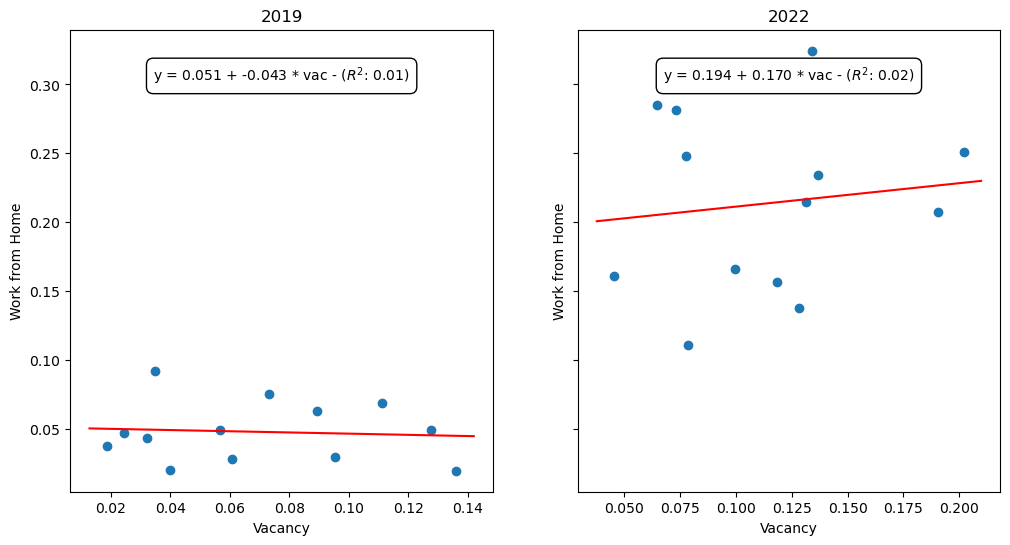

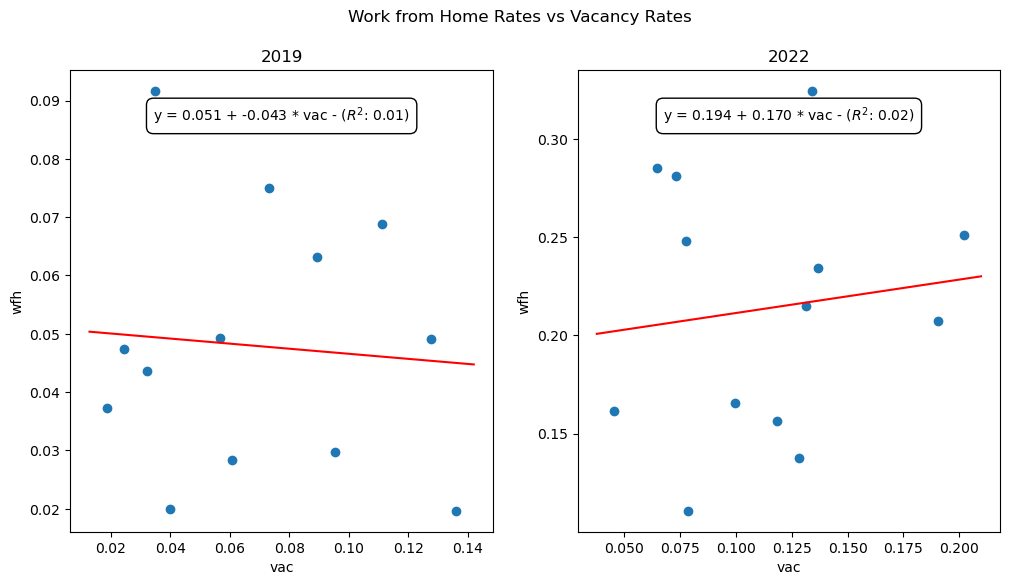

In [98]:
import statsmodels.api as sm
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for i,(nme,dta) in enumerate(data.groupby('year')):
    print(nme)


    axes[i].scatter(dta['vac'], dta['wfh'])
    axes[i].set_title(nme)
    axes[i].set_xlabel('Vacancy')
    axes[i].set_ylabel('Work from Home')
    y = dta['wfh']
    X = dta['vac']
    X = sm.add_constant(X)

    model = sm.OLS(y,X, hasconst=True)
    results = model.fit()
    results.params
    
    # Annotate the subplot with the regression equation
    annotate_regression_equation(axes[i], results, X)
    plot_regression_line(axes[i], results, X)


import statsmodels.api as sm
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
for i, (nme, dta) in enumerate(data.groupby('year')):
    print(nme)

    # pick the two vars for the scatter - a bit arbitrary what goes where, but conceptually, 
    # we could say a higher work from home rate "predicts" higher vacancies
    
    y = dta['wfh']
    X = dta['vac']

    axes[i].scatter(X, y)
    axes[i].set_title(nme)
    axes[i].set_xlabel(X.name)
    axes[i].set_ylabel(y.name)
    X = sm.add_constant(X)

    model = sm.OLS(y, X, hasconst=True)
    results = model.fit()

    # Annotate the subplot with the regression equation
    annotate_regression_equation(axes[i], results, X)
    plot_regression_line(axes[i], results, X)
plt.suptitle('Work from Home Rates vs Vacancy Rates')

## place of work - county - excluding WFH

In [101]:
# load place of work data, county level
commute_multi_year_county_abs = pd.read_csv(
    '/Users/aolsen/Box/Modeling and Surveys/Census/processed/B08501_acs1_multiyear_county_jobs_abs.csv')

commute_multi_year_county_abs = commute_multi_year_county_abs.rename(
    columns={'Unnamed: 2': 'variable'})

# format county name
commute_multi_year_county_abs['county'] = commute_multi_year_county_abs.NAME.str.replace(
    ' County, California', '').str.strip()

# drop wfh from place of work jobs universe - those are not, we assume, typically in CRE
commute_multi_year_county_no_wfh = commute_multi_year_county_abs.query(
    'variable!="Estimate!!Total:!!Worked from home:" ')
county_jobs_truncated = commute_multi_year_county_no_wfh.groupby(
    'county').sum().drop(['stcounty'], axis=1)

county_jobs_not_truncated = commute_multi_year_county_abs.groupby(
    'county').sum().drop(['stcounty'], axis=1)
commute_multi_year_county_with_wfh = commute_multi_year_county_abs.copy()
commute_multi_year_county_with_wfh.head()

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/953035750.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  'county').sum().drop(['stcounty'], axis=1)
/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/953035750.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  'county').sum().drop(['stcounty'], axis=1)


,NAME,stcounty,variable,2019,2021,2022,county
0,"Alameda County, California",6001,"Estimate!!Total:!!Car, truck, or van - carpooled:","73,905.00","62,780.00","71,254.00",Alameda
1,"Alameda County, California",6001,"Estimate!!Total:!!Car, truck, or van - drove a...","533,679.00","435,993.00","461,217.00",Alameda
2,"Alameda County, California",6001,Estimate!!Total:!!Public transportation (exclu...,"62,939.00","21,869.00","34,009.00",Alameda
3,"Alameda County, California",6001,"Estimate!!Total:!!Taxicab, motorcycle, bicycle...","24,448.00","21,826.00","25,511.00",Alameda
4,"Alameda County, California",6001,Estimate!!Total:!!Walked:,"21,871.00","19,201.00","21,414.00",Alameda


# Reduce job counts based on estimates of office employment

## naics to land use 
We use SF's commerce and industry report which contains a table mapping industry codes to land use category.

In [102]:
def seq_fill(s):
    if len(s)>1:
        out = np.arange(int(s[0]),1+int(s[1]))
    else:
        out=s
    return out
    

In [103]:
land_use_path = '/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/SF planning land use to NAICS.xlsx'

luse = pd.read_excel(
    land_use_path, skiprows=1)
luse = luse.dropna(subset=['NAICS'])
luse.head()

,Landuse,Industry Group,NAICS
0,Office,NaN,111-115
1,NaN,Agriculture,211-213
2,NaN,Finance,522-523
3,NaN,Insurance,524-525
4,NaN,Real Estate,"531, 533"


In [104]:
# forward fill missing values
luse.Landuse = luse.Landuse.fillna(method='ffill')

# explode comma separated strings
luse_expl_1 = luse.NAICS.astype(str).str.split(',').explode().str.strip()

# then split on hyphens, and use first and second elements range endpoints
luse_expl_2 = luse_expl_1.str.split('-').apply(seq_fill)

# explode on those enumerated ranges, turn to strings
luse_expl_3 = luse_expl_2.explode().astype(str)

# merge back to original DF
naics_to_luse = luse.merge(luse_expl_3, left_index=True,
                           right_index=True).set_index('NAICS_y').Landuse

# naics-3 digit mapping to land use classification
naics_to_luse

NAICS_y
111                                      Office
112                                      Office
113                                      Office
114                                      Office
115                                      Office
                         ...                   
624    Cultural/Institutional/Educational (CIE)
712    Cultural/Institutional/Educational (CIE)
813    Cultural/Institutional/Educational (CIE)
814                          Private Households
999                          Private Households
Name: Landuse, Length: 99, dtype: object

## QCEW Data

In [105]:
QCEW_2015_PATH = '/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Downloads/2015.q1-q4.singlefile.csv'
QCEW_2019_PATH = '/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Downloads/CSV/2019.q1-q4.singlefile.csv'
QCEW_2023_PATH = '/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Downloads/2023.q1-q2.singlefile.csv'

In [106]:
qcew_fields = ['agglvl_code','qtr','area_fips','industry_code','month3_emplvl']

In [107]:
qcew_2023 = pd.read_csv(
    QCEW_2023_PATH, usecols=qcew_fields, dtype={'area_fips': str, 'industry_code': 'str'})

In [108]:
qcew_2015 = pd.read_csv(
    QCEW_2015_PATH, usecols=qcew_fields, dtype={'area_fips': str, 'industry_code': 'str'})

In [109]:
qcew_2019 = pd.read_csv(
    QCEW_2019_PATH, usecols=qcew_fields, dtype={'area_fips': str, 'industry_code': 'str'})

In [110]:
# Map counties to files
qcew_2015['county'] = qcew_2015.area_fips.map(bayareafips_full)
qcew_2019['county'] = qcew_2019.area_fips.map(bayareafips_full)
qcew_2023['county'] = qcew_2023.area_fips.map(bayareafips_full)

In [111]:
# qtr 1, month 3 (march) jobs by county
# 2015

qcew_jobs_by_county_2015 = (qcew_2015.loc[
    (qcew_2015.area_fips.isin(bayareafips_full))
    & (qcew_2015.qtr == 1)
    & (qcew_2015.agglvl_code == 70)].groupby('county').month3_emplvl.sum())

# 2019
qcew_jobs_by_county_2019 = (qcew_2019.loc[
    (qcew_2019.area_fips.isin(bayareafips_full))
    & (qcew_2019.qtr == 1)
    & (qcew_2019.agglvl_code == 70)].groupby('county').month3_emplvl.sum())

# 2023
qcew_jobs_by_county_2023 = (qcew_2023.loc[
    (qcew_2023.area_fips.isin(bayareafips_full))
    & (qcew_2023.qtr == 1)
    & (qcew_2023.agglvl_code == 70)].groupby('county').month3_emplvl.sum())

# create jobs df for years 2019, 2023
qcew_jobs_by_county_2019_2023 = pd.concat(
    [qcew_jobs_by_county_2015, qcew_jobs_by_county_2019, qcew_jobs_by_county_2023], axis=1, 
    keys=['2015','2019', '2023'])

In [112]:
# jobs by industry 2023

qcew_2023_bayarea = qcew_2023.loc[(qcew_2023.area_fips.isin(
    bayareafips_full))
    & (qcew_2023.qtr == 1)
    & (qcew_2023.agglvl_code == 75)]

# assign land use from naics
qcew_2023_bayarea['landuse'] = qcew_2023_bayarea.industry_code.map(
    naics_to_luse)

# get jobs by land use by county

qcew_jobs_by_landuse_by_county = qcew_2023_bayarea.groupby(
    ['county', 'landuse']).month3_emplvl.sum()
qcew_jobs_by_landuse_by_county_pct = qcew_jobs_by_landuse_by_county.groupby(
    level='county').apply(pct)
qcew_office_shares_by_county = qcew_jobs_by_landuse_by_county_pct.loc[:, 'Office']
qcew_jobs_by_landuse_by_county_pct.unstack(1)

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/862818890.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qcew_2023_bayarea['landuse'] = qcew_2023_bayarea.industry_code.map(
/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58248/862818890.py:17: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  level='county').apply(pct)


landuse,Cultural/Institutional/Educational (CIE),Hotel or Visitor,Office,Private Households,Production/Distribution/Repair (PDR),Retail
county,,,,,,
Alameda,0.30,0.01,0.27,0.00,0.29,0.13
Contra Costa,0.34,0.01,0.27,0.00,0.21,0.17
Marin,0.32,0.01,0.28,0.01,0.18,0.19
Napa,0.21,0.07,0.23,0.00,0.33,0.16
San Francisco,0.27,0.02,0.47,0.00,0.13,0.11
San Mateo,0.22,0.01,0.38,0.01,0.24,0.14
Santa Clara,0.26,0.01,0.31,0.00,0.30,0.12
Solano,0.34,0.01,0.20,0.00,0.27,0.18
Sonoma,0.30,0.02,0.23,0.00,0.29,0.16


## Now, we can estimate office jobs by county

In [113]:
# apply these bls-derived office shares to ACS jobs

# ACS truncated data
est_county_office_jobs_truncated = county_jobs_truncated.loc[:, [
    '2019', '2022']].mul(qcew_office_shares_by_county, axis=0).round(0).astype(int)
est_county_office_jobs_truncated

,2019,2022
county,,
Alameda,192275,164531
Contra Costa,101879,91792
Marin,30108,25744
Napa,17481,15867
San Francisco,354126,211833
San Mateo,152234,120819
Santa Clara,347052,262910
Solano,29117,26488
Sonoma,49045,44495


In [114]:
# Relating full jobs place of work universe to actually occuped office space

# Version A: ACS not truncated data (but folks working from home in a different county still don't appear in these data)
est_county_office_jobs_not_truncated = county_jobs_not_truncated.loc[:, [
    '2019', '2022']].mul(qcew_office_shares_by_county, axis=0).round(0).astype(int)
est_county_office_jobs_not_truncated

,2019,2022
county,,
Alameda,206554,227303
Contra Costa,112431,122968
Marin,35192,37150
Napa,18473,17631
San Francisco,372467,282769
San Mateo,161764,156662
Santa Clara,362317,338618
Solano,31180,31713
Sonoma,53688,52495


In [115]:
# apply bls-derived office shares to BLS QCEW jobs - which does not suffer from the ACS-related partial truncation

# Version B: BLS not truncated data
est_county_office_jobs_not_truncated = qcew_jobs_by_county_2019_2023.mul(
    qcew_office_shares_by_county, axis=0).round(0).astype(int)
est_county_office_jobs_not_truncated

,2015,2019,2023
county,,,
Alameda,193146,211996,212010
Contra Costa,92376,99525,99064
Marin,31398,32660,31058
Napa,17072,18228,18129
San Francisco,309870,352807,342433
San Mateo,141820,153437,157901
Santa Clara,314947,349314,350945
Solano,25244,27801,26896
Sonoma,44088,47558,46675


# Estimate job density factors de novo, county level

We have county level office vacancy data, and county level office employment. We can use that to get average (occupied) space per worker rates.

In [116]:
BAUS_OFFICE_CONSTANT = 359

In [117]:
# Load mainly for schema

empl_density_factors = pd.read_csv(
    '/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/bayarea_urbansim/configs/adjusters/sqft_per_job_adjusters.csv')
empl_density_factors.head(2).columns
factors_schema = ['number', 'name', 'sqft_per_job_factor']
empl_density_factors['sqft_per_job_factor_adj'] = empl_density_factors.sqft_per_job_factor.mul(
    BAUS_OFFICE_CONSTANT)
empl_density_factors

,number,name,sqft_per_job_factor,sqft_per_job_factor_adj
0,1,SF NE,1.21,435.14
1,2,SF NW,1.03,370.09
2,3,SF S SE,1.45,522.17
3,4,SF SW,1.69,608.35
4,5,Daly City Millbrae,0.97,347.99
5,6,San Mateo,0.92,330.26
6,7,Redwood City,0.97,347.99
7,8,Palo Alto,0.92,330.39
8,9,Golden Triangle,0.89,320.81
9,10,West San Jose,0.92,330.39


In [118]:
denominator_jobs_truncated = est_county_office_jobs_truncated
denominator_jobs_truncated.columns = denominator_jobs_truncated.columns.astype(int)

In [119]:
denominator_jobs_not_truncated = est_county_office_jobs_not_truncated
denominator_jobs_not_truncated.columns = denominator_jobs_not_truncated.columns.astype(
    int)

In [120]:
# # new implied density, with more wfh - across the board, less efficient utilization

def calculate_job_density_factors(numerator_space,
                                  denominator_jobs,
                                  county_x_superdist,
                                  empl_density_factors):

    job_density_from_to = numerator_space.div(
        denominator_jobs)

    # expand county-level factors to superdistricts within
    job_density_from_to_to_superdist_truncated = job_density_from_to.join(
        county_x_superdist)

    job_density_from_to_to_superdist_truncated = job_density_from_to_to_superdist_truncated.reset_index()

    job_density_from_to_to_superdist_truncated = job_density_from_to_to_superdist_truncated.rename(
        columns={'index': 'county', 'superdistr': 'number'})

    job_density_from_to_to_superdist_truncated['name'] = job_density_from_to_to_superdist_truncated.number.map(
        empl_density_factors.set_index('number').name)

    # ratio 2022 to 2019
    job_density_from_to_to_superdist_truncated['sqft_per_job_factor_2023_to_2019'] = job_density_from_to_to_superdist_truncated[2023] / \
        job_density_from_to_to_superdist_truncated[2019]

    # take halfway increase between 2019 and 2022 - as a ratio relative to 2019.
    job_density_from_to_to_superdist_truncated['sqft_per_job_factor_midpoint'] = (job_density_from_to_to_superdist_truncated[2019] + (
        job_density_from_to_to_superdist_truncated[2023] -
        job_density_from_to_to_superdist_truncated[2019]).div(2)).div(job_density_from_to_to_superdist_truncated[2019])

    # take 2022 density levels relative to the BAUS 350 sqft/worker constant

    job_density_from_to_to_superdist_truncated[f'sqft_per_job_factor_2023_vs_{BAUS_OFFICE_CONSTANT}'] = job_density_from_to_to_superdist_truncated[2023].div(
        BAUS_OFFICE_CONSTANT)

    return job_density_from_to_to_superdist_truncated

In [121]:
# create a density version from *not* truncated jobs - (as in, WFH jobs not removed)

job_density_2019_2022_to_superdist_not_truncated = calculate_job_density_factors(
    numerator_space, denominator_jobs_not_truncated, county_x_superdist, empl_density_factors)
job_density_2019_2022_to_superdist_not_truncated.head()

,county,2015,2019,2023,number,name,sqft_per_job_factor_2023_to_2019,sqft_per_job_factor_midpoint,sqft_per_job_factor_2023_vs_359
0,Alameda,336.97,323.51,314.77,15,Tri Valley,0.97,0.99,0.88
1,Alameda,336.97,323.51,314.77,16,Fremont,0.97,0.99,0.88
2,Alameda,336.97,323.51,314.77,17,S Leandro Hayward,0.97,0.99,0.88
3,Alameda,336.97,323.51,314.77,18,Oakland Alameda,0.97,0.99,0.88
4,Alameda,336.97,323.51,314.77,19,Berkeley Eville,0.97,0.99,0.88


In [122]:
# this won't work now that we moved to the year 2023

# job_density_2019_2022_to_superdist_truncated = calculate_job_density_factors(
#     numerator_space, denominator_jobs_truncated, county_x_superdist, empl_density_factors)
# job_density_2019_2022_to_superdist_truncated

## Not time-varying factors


### Generate single-estimate blanket factors by superdistrict for reading into BAUS


In [123]:


spread_vals = [.5, .75, 1.25, 1.5]
base_density_steps = pd.Series(
    BAUS_OFFICE_CONSTANT, index=range(1, 35)).to_frame('base_density')
base_density_steps['name'] = empl_density_factors.set_index('number').name
base_density_steps['number'] = base_density_steps.index
base_variants = []
for val in spread_vals:
    print('Generating factors by superdistrict with this value: ',val)
    if val < 1:
        new_name = f'base_density_minus_{(100-val*100):.0f}pct'
    else:
        new_name = f'base_density_plus_{(val*100-100):.0f}pct'

    base_variants.append(new_name)

    # actually we just need the factor for multiplication with the base rate, which happens in baus
    base_density_steps[new_name] = val

    out_path = f'/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/bayarea_urbansim/configs/adjusters/sqft_per_job_adjusters_{new_name}_constant.csv'
    out_factors = base_density_steps.rename(
        columns={new_name: 'sqft_per_job_factor'})[factors_schema]
    out_factors.to_csv(out_path)


Generating factors by superdistrict with this value:  0.5
Generating factors by superdistrict with this value:  0.75
Generating factors by superdistrict with this value:  1.25
Generating factors by superdistrict with this value:  1.5


### Also not time varying - but empirical
for each of these pre-defined density measures, grab that column and  write out a target file, rename accordingly

In [124]:
variants = ['sqft_per_job_factor_2023_to_2019',
            'sqft_per_job_factor_midpoint', 'sqft_per_job_factor_2023_vs_359']

for v in variants:
    #out_path = f'/Users/aolsen/Box/Modeling and Surveys/Urban Modeling/Bay Area UrbanSim/PBA50Plus_Development/Exogenous/bayarea_urbansim/configs/adjusters/sqft_per_job_adjusters_{v}.csv'
    out_path = f'/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/bayarea_urbansim/configs/adjusters/sqft_per_job_adjusters_{v}_not_truncated.csv'
    out_factors = job_density_2019_2022_to_superdist_not_truncated.rename(
        columns={v: 'sqft_per_job_factor'})[factors_schema]
    out_factors.to_csv(out_path)
out_factors.head()

,number,name,sqft_per_job_factor
0,15,Tri Valley,0.88
1,16,Fremont,0.88
2,17,S Leandro Hayward,0.88
3,18,Oakland Alameda,0.88
4,19,Berkeley Eville,0.88


### Simple constant adjusters - across the board, no time dimension

In [143]:
base_variants = []
for val in spread_vals:
    if val < 1:
        new_name = f'base_density_minus_{(100-val*100):.0f}pct'
    else:
        new_name = f'base_density_plus_{(val*100-100):.0f}pct'

    base_variants.append(new_name)

for v in base_variants:
    print('Creating constant factors by superdist: ', v)
    out_path = f'/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/bayarea_urbansim/configs/adjusters/sqft_per_job_adjusters_{v}_constant.csv'
    out_factors = base_density_steps.rename(
        columns={v: 'sqft_per_job_factor'})[factors_schema]
    out_factors.to_csv(out_path)
out_factors.head()

Creating constant factors by superdist:  base_density_minus_50pct
Creating constant factors by superdist:  base_density_minus_25pct
Creating constant factors by superdist:  base_density_plus_25pct
Creating constant factors by superdist:  base_density_plus_50pct


,number,name,sqft_per_job_factor
1,1,SF NE,1.50
2,2,SF NW,1.50
3,3,SF S SE,1.50
4,4,SF SW,1.50
5,5,Daly City Millbrae,1.50


## Time-varying factors

Now, we are looking for a dataframe of factors with a year-specific adjuster - meaning we adjust space per worker in future years

In [125]:
# starting series of constants by SD
superdist_constant_density = pd.Series(
    BAUS_OFFICE_CONSTANT, index=pd.MultiIndex.from_frame(superdist_records.reset_index()))
superdist_constant_density.head()

number  name             
15      Tri Valley           359
16      Fremont              359
17      S Leandro Hayward    359
18      Oakland Alameda      359
19      Berkeley Eville      359
dtype: int64

In [126]:
# base-adjusted version
superdist_constant_density_adj = empl_density_factors.set_index(
    ['number', 'name']).sqft_per_job_factor_adj

In [127]:
def add_time_dimension_to_density_factor(
        phase_start_year,
        phase_end_year,
        value_factor,
        data_frame,
        out_start_year=2010,
        out_end_year=2051):

    # how many years between end and start year?
    duration = phase_end_year - phase_start_year

    # make an array of years from start_year to end_year
    years = np.arange(phase_start_year, phase_end_year + 1)

    # get the progression of time as a series of steps from 0 to 1
    time_progression_steps = (years - phase_start_year) / duration

    # calculate the progression of time using a cosine function to create smooth growth
    time_progression_series = pd.Series(
        data=(1 - np.cos(np.pi * time_progression_steps)) / 2,
        index=years
    )

    # function to multiply the progression with the value factor (
    # how much to grow the starting value by the time frame)
    def multiply_progression(row):
        # move rows ahead, in "native" units (around 300)
        row_progression = row * \
            (1 + (time_progression_series * (value_factor - 1)))

        return row_progression

    # then apply the multiplication function to the input data_frame
    result = data_frame.apply(multiply_progression).stack().unstack([0, 1])

    # fill forward and backward for annual observations in case we don't pass the whole projection period
    result = result.reindex(np.arange(out_start_year, out_end_year), method='ffill').fillna(
        method='bfill').loc[range(out_start_year, out_end_year, 5)].T

    return result.rename(columns=lambda x: f'sqft_per_job_factor_{x}')

### Start with Costar to QCEW observed rates, then evolve at constant rate

start with costar occupied space to qcew on-paper jobs, then reduce by 10-20% by 2035 note this is blanket increases or decreases from 2023 levels - it is not a roll back necessarily as some counties saw a drop in efficiency while others saw an increase 2019-2023. Roll back to 2019 means an increase for some, a decrease for others.

We vary the decrease here - phasing out the space increase idea. A new variant is that instead of starting at 2023, we make a version taking the PBA50 starting levels (that is, 359 times time-invariant adjusters in  [sqft_per_job_adjusters.csv](https://github.com/BayAreaMetro/bayarea_urbansim/blob/main/configs/adjusters/sqft_per_job_adjusters.csv)

In [128]:
# Generate a set of input density factor adjusters:

file_list = []

# make covenience kwargs dicts to pass to the add_time_dimension_to_density_factor function for easy iteration
# biggest difference is one takes a starting point in 2010 rates while the other uses 2023 levels

kw_map_2010 = {'phase_start_year': 2025,
               'phase_end_year': 2035,
               'data_frame': superdist_constant_density_adj,
               'out_start_year': 2015,
               'out_end_year': 2051}

kw_map_2023 = {'phase_start_year': 2025,
               'phase_end_year': 2035,
               'data_frame': job_density_2019_2022_to_superdist_not_truncated.set_index(['number', 'name'])[2023],
               'out_start_year': 2020,
               'out_end_year': 2051}

# mapping adjustment level names to adjustment levels
vf_map = {'0p8_reduction': .8, '0p9_reduction': .9,
          'stasis': 1}# '1p1_increase': 1.1, '1p2_increase': 1.2}

# iterate through both dicts
for key, value_factor in vf_map.items():
    print(key)

    for bsnme, kwargs in {'base_2010': kw_map_2010, 'base_2023': kw_map_2023}.items():

        time_varying_density = add_time_dimension_to_density_factor(
            value_factor=value_factor, **kwargs)

        # divide by the constant office density to get factors relative to that by superdistrict, by time
        time_varying_density_relative = time_varying_density.div(
            BAUS_OFFICE_CONSTANT)

        if bsnme == 'base_2023':
            print('\tAdding 2015, updating 2020')
            for year in [2015, 2020]:
                time_varying_density_relative[f'sqft_per_job_factor_{year}'] = superdist_constant_density_adj.div(
            BAUS_OFFICE_CONSTANT)

        # write empirical, time and space varying adjuster
        out_path = f'/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/bayarea_urbansim/configs/adjusters/sqft_per_job_adjusters_costar_qcew_timevarying_{bsnme}_{key}.csv'
        time_varying_density_relative.to_csv(out_path)
        file_list.append(out_path.split('/')[-1])

0p8_reduction
	Adding 2015, updating 2020
0p9_reduction
	Adding 2015, updating 2020
stasis
	Adding 2015, updating 2020


In [129]:
import yaml

run_setup_template = '/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/run_setup.yaml'
with open(run_setup_template, "r") as f:
    run_setup = yaml.safe_load(f)

for i, fn in enumerate(file_list):
    run_setup_exog = f'/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/run_setup_{i+30:02d}.yaml'
    run_setup['sqft_per_job_adj_file'] = fn
    run_setup['run_id'] = f'Run_{i+30:02d}'
    run_setup['run_name'] = f'Run_{i+30:02d}_{fn[:-4]}'

    with open(run_setup_exog, 'w') as f:
        yaml.dump(run_setup, f, sort_keys=False)

In [130]:
#     time_varying_density = add_time_dimension_to_density_factor(
#         phase_start_year=2025,
#         phase_end_year=2036, value_factor=value_factor,
#         data_frame=job_density_2019_2022_to_superdist_not_truncated.set_index(['number', 'name'])[
#             2023],
#         out_start_year=2020,
#         out_end_year=2051
#         # superdist_constant_density
#     )
#     # divide by the constant office density to get factors relative to that by superdistrict, by time
#     time_varying_density_relative = time_varying_density.div(BAUS_OFFICE_CONSTANT)

#     # write empirical, time and space varying adjuster
#     out_path = f'/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/bayarea_urbansim/configs/adjusters/sqft_per_job_adjusters_costar_qcew_timevarying_{key}.csv'
#     time_varying_density_relative.to_csv(out_path)

#     print(time_varying_density_relative.loc[1])

###  Start with Costar to QCEW observed rates, then evolve at county-specific historic rate, either up or down

This means that:
* a superdistrict which sees a decline since 2015 to 2023 can carry that decline forward, and continue decline
* a superdistrict which sees an increase since 2015 to 2023 can carry that increase forward, and continue decline

In other words, each superdistrict continues its own trajectory. We added a flag so they can *change* directory, but still superdistrict-specific.



In [131]:
# make a little easer function to smooth a progression series
def apply_easing(x):
    return 0.5 - 0.5 * np.cos(x * np.pi)

In [137]:
def project_forward(df, year_1, year_2, future_years, k, reverse=False):

    starting_series = df[year_2]
    starting_series.name = 'start'
    
    # Calculate the annual rate of change
    annual_rate = (df[year_2] - df[year_1]) / df[year_1]

    annual_rate.name = 'chg'

    # Apply the growth envelope with sinusoidal easing across future years
    # returns a series ranging from 0 to 1 during a span of future_years
    easing_values = apply_easing(np.linspace(0, 1, future_years))
    easing_years = range(year_2+1, year_2+future_years+1)
    # Create a df with easing values repeated for each row
    easing_df = pd.DataFrame(np.tile(easing_values, (len(df), 1)),
                             columns=easing_years,
                             index=df.index)

    # Multiply easing values with the growth envelope and k
    df = easing_df.mul(1 + starting_series * k,
                       axis=0).add(starting_series, axis=0)

    eased_time_progression = easing_df.mul(annual_rate * k, axis=0)

    # add option to switch direction - that is, we take the same magnitude of change, but assume an inflection point
    if reverse:
        eased_progression_on_starting_series = eased_time_progression.mul(
            -1).add(1).mul(starting_series, axis=0)
    else:
        eased_progression_on_starting_series = eased_time_progression.add(
            1).mul(starting_series, axis=0)
        
    eased_progression_to_endpoint = eased_progression_on_starting_series.reindex(np.arange(2024, 2051), method='ffill',axis=1)    
    eased_progression_to_endpoint = eased_progression_to_endpoint.rename(columns=lambda x: f'sqft_per_job_factor_{x}')
    
    return eased_progression_to_endpoint

    # Create a dataframe for the projected values
    result_df = pd.DataFrame(index=df.index, columns=[
                             f'projected_year_{i}' for i in range(1, future_years + 1)])

    # Fill in the projected values for each future year
    for i in range(1, future_years + 1):
        result_df[f'projected_year_{i}'] = df['projected']

    # Concatenate the county and projected values
    result_df = pd.concat([df['county'], result_df], axis=1)

    return result_df

In [140]:
# call function, and write to disk

superdist_timevarying_trend_reversal = project_forward(job_density_2019_2022_to_superdist_not_truncated.set_index(['number', 'name']),
                                                       2015, 2023, 15, 2, reverse=True)

key = 'actual_sd_reversal'
out_path = f'/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/bayarea_urbansim/configs/adjusters/sqft_per_job_adjusters_costar_qcew_timevarying_{key}.csv'
(superdist_timevarying_trend_reversal/BAUS_OFFICE_CONSTANT).to_csv(out_path)

superdist_timevarying_trend_reversal.head()

,,sqft_per_job_factor_2024,sqft_per_job_factor_2025,sqft_per_job_factor_2026,sqft_per_job_factor_2027,sqft_per_job_factor_2028,sqft_per_job_factor_2029,sqft_per_job_factor_2030,sqft_per_job_factor_2031,sqft_per_job_factor_2032,sqft_per_job_factor_2033,...,sqft_per_job_factor_2041,sqft_per_job_factor_2042,sqft_per_job_factor_2043,sqft_per_job_factor_2044,sqft_per_job_factor_2045,sqft_per_job_factor_2046,sqft_per_job_factor_2047,sqft_per_job_factor_2048,sqft_per_job_factor_2049,sqft_per_job_factor_2050
number,name,,,,,,,,,,,,,,,,,,,,,
15,Tri Valley,314.77,315.29,316.82,319.29,322.57,326.51,330.89,335.50,340.12,344.50,...,356.24,356.24,356.24,356.24,356.24,356.24,356.24,356.24,356.24,356.24
16,Fremont,314.77,315.29,316.82,319.29,322.57,326.51,330.89,335.50,340.12,344.50,...,356.24,356.24,356.24,356.24,356.24,356.24,356.24,356.24,356.24,356.24
17,S Leandro Hayward,314.77,315.29,316.82,319.29,322.57,326.51,330.89,335.50,340.12,344.50,...,356.24,356.24,356.24,356.24,356.24,356.24,356.24,356.24,356.24,356.24
18,Oakland Alameda,314.77,315.29,316.82,319.29,322.57,326.51,330.89,335.50,340.12,344.50,...,356.24,356.24,356.24,356.24,356.24,356.24,356.24,356.24,356.24,356.24
19,Berkeley Eville,314.77,315.29,316.82,319.29,322.57,326.51,330.89,335.50,340.12,344.50,...,356.24,356.24,356.24,356.24,356.24,356.24,356.24,356.24,356.24,356.24


In [141]:
superdist_timevarying_trend_continuation = project_forward(job_density_2019_2022_to_superdist_not_truncated.set_index(['number', 'name']),
                                                           2015, 2023, 15, 2, reverse=False)

key = 'actual_sd_continuation'
out_path = f'/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/bayarea_urbansim/configs/adjusters/sqft_per_job_adjusters_costar_qcew_timevarying_{key}.csv'
(superdist_timevarying_trend_continuation /
 BAUS_OFFICE_CONSTANT).to_csv(out_path)

superdist_timevarying_trend_continuation.head()

,,sqft_per_job_factor_2024,sqft_per_job_factor_2025,sqft_per_job_factor_2026,sqft_per_job_factor_2027,sqft_per_job_factor_2028,sqft_per_job_factor_2029,sqft_per_job_factor_2030,sqft_per_job_factor_2031,sqft_per_job_factor_2032,sqft_per_job_factor_2033,...,sqft_per_job_factor_2041,sqft_per_job_factor_2042,sqft_per_job_factor_2043,sqft_per_job_factor_2044,sqft_per_job_factor_2045,sqft_per_job_factor_2046,sqft_per_job_factor_2047,sqft_per_job_factor_2048,sqft_per_job_factor_2049,sqft_per_job_factor_2050
number,name,,,,,,,,,,,,,,,,,,,,,
15,Tri Valley,314.77,314.25,312.71,310.24,306.96,303.03,298.64,294.03,289.41,285.03,...,273.29,273.29,273.29,273.29,273.29,273.29,273.29,273.29,273.29,273.29
16,Fremont,314.77,314.25,312.71,310.24,306.96,303.03,298.64,294.03,289.41,285.03,...,273.29,273.29,273.29,273.29,273.29,273.29,273.29,273.29,273.29,273.29
17,S Leandro Hayward,314.77,314.25,312.71,310.24,306.96,303.03,298.64,294.03,289.41,285.03,...,273.29,273.29,273.29,273.29,273.29,273.29,273.29,273.29,273.29,273.29
18,Oakland Alameda,314.77,314.25,312.71,310.24,306.96,303.03,298.64,294.03,289.41,285.03,...,273.29,273.29,273.29,273.29,273.29,273.29,273.29,273.29,273.29,273.29
19,Berkeley Eville,314.77,314.25,312.71,310.24,306.96,303.03,298.64,294.03,289.41,285.03,...,273.29,273.29,273.29,273.29,273.29,273.29,273.29,273.29,273.29,273.29


### Use blanket constants, rather than adjusters - can't be used as is in the current model setup
This is just because it expects adjusters to the constant, so 1.x or something, which is then multiplied with 359

In [142]:
start_year, end_year = 2025, 2035
add_time_dimension_to_density_factor(start_year,
                                     end_year, 1.5, superdist_constant_density).head()

,,sqft_per_job_factor_2010,sqft_per_job_factor_2015,sqft_per_job_factor_2020,sqft_per_job_factor_2025,sqft_per_job_factor_2030,sqft_per_job_factor_2035,sqft_per_job_factor_2040,sqft_per_job_factor_2045,sqft_per_job_factor_2050
number,name,,,,,,,,,
15,Tri Valley,359.00,359.00,359.00,359.00,448.75,538.50,538.50,538.50,538.50
16,Fremont,359.00,359.00,359.00,359.00,448.75,538.50,538.50,538.50,538.50
17,S Leandro Hayward,359.00,359.00,359.00,359.00,448.75,538.50,538.50,538.50,538.50
18,Oakland Alameda,359.00,359.00,359.00,359.00,448.75,538.50,538.50,538.50,538.50
19,Berkeley Eville,359.00,359.00,359.00,359.00,448.75,538.50,538.50,538.50,538.50


### Constant adjusters by space - but phased over time

In [181]:
end_year = 2035
start_year = 2020

# how much to grow the starting value by the time frame
#value_factor = 1.25

for val in [.5, .75, 1.25, 1.5]:
    out_factors = add_time_dimension_to_density_factor(start_year,
                                                       end_year, val, superdist_constant_density)
    
    # normalize relative to starting constant
    out_factors = out_factors.div(BAUS_OFFICE_CONSTANT)
    if val < 1:
        new_name = f'base_density_minus_{(100-val*100):.0f}pct'
    else:
        new_name = f'base_density_plus_{(val*100-100):.0f}pct'
    out_path = f'/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/bayarea_urbansim/configs/adjusters/sqft_per_job_adjusters_{new_name}_timevarying.csv'
    out_factors.to_csv(out_path)
out_factors.head()

,,sqft_per_job_factor_2010,sqft_per_job_factor_2015,sqft_per_job_factor_2020,sqft_per_job_factor_2025,sqft_per_job_factor_2030,sqft_per_job_factor_2035,sqft_per_job_factor_2040,sqft_per_job_factor_2045,sqft_per_job_factor_2050
number,name,,,,,,,,,
15,Tri Valley,1.00,1.00,1.00,1.12,1.38,1.50,1.50,1.50,1.50
16,Fremont,1.00,1.00,1.00,1.12,1.38,1.50,1.50,1.50,1.50
17,S Leandro Hayward,1.00,1.00,1.00,1.12,1.38,1.50,1.50,1.50,1.50
18,Oakland Alameda,1.00,1.00,1.00,1.12,1.38,1.50,1.50,1.50,1.50
19,Berkeley Eville,1.00,1.00,1.00,1.12,1.38,1.50,1.50,1.50,1.50


In [173]:
# # divide by the constant office density to get factors relative to that by superdistrict, by time
# time_varying_density_relative = time_varying_density.div(BAUS_OFFICE_CONSTANT)
# time_varying_density_relative

# Check EN7 telecommuting constants

In [174]:
teleadj = pd.read_csv(
    '/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/inputs/plan_strategies/telecommute_sqft_per_job_adjusters.csv')

In [175]:
teleadj['county'] = teleadj.number.map(
    zones.groupby(['superdistr']).county_name.first())

In [176]:
teleadj_long = teleadj.set_index(['number', 'name', 'county'])
teleadj_long.columns = teleadj_long.columns.str.extract(
    '(\d{4})$', expand=False).astype(int)
teleadj_long = teleadj_long.stack()
teleadj_long.groupby(level=['county', 3]).mean().unstack(0)

county,Alameda,Contra Costa,Marin,Napa,San Francisco,San Mateo,Santa Clara,Solano,Sonoma
2015,0.96,0.98,1.00,1.00,1.29,0.95,0.93,1.05,0.99
2020,0.96,0.98,1.00,1.01,1.24,0.94,0.93,1.05,1.02
2025,0.96,0.98,0.99,1.03,1.19,0.94,0.92,1.05,1.05
2030,0.95,0.97,0.99,1.04,1.13,0.93,0.92,1.05,1.07
2035,0.95,0.97,0.99,1.06,1.08,0.93,0.92,1.05,1.10
2040,0.94,0.96,0.99,1.07,1.02,0.92,0.91,1.05,1.13
2045,0.94,0.96,0.99,1.09,0.97,0.92,0.91,1.05,1.15
2050,0.94,0.96,0.98,1.10,0.91,0.92,0.90,1.05,1.18


In [177]:
teleadj['geometry'] = teleadj.number.map(
    superdistricts.set_index('superdistr').geometry)
teleadj = teleadj.set_geometry('geometry')

In [205]:
#teleadj.explore(column='sqft_per_job_factor_2015')

In [218]:
# tazmargs = pd.read_csv('/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Contingency Income Test/inputs/basis_inputs/parcels_buildings_agents/TAZ1454_2020_Land_Use.csv')
# tazmargs[['HHINCQ1', 'HHINCQ2', 'HHINCQ3', 'HHINCQ4']].describe()

In [219]:
# controls = pd.read_csv('/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Contingency Income Test/inputs/regional_controls/household_controls.csv')

In [220]:
# controls.query('year==2020')

In [623]:
# reloc_adjuster_in_path = '/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/bayarea_urbansim/configs/adjusters/employment_relocation_rates_overwrites.csv'
# reloc_adjuster_out_path = '/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/bayarea_urbansim/configs/adjusters/employment_relocation_rates_adj_fps_reduced_6pct.csv'
# reloc_adjusters = pd.read_csv(reloc_adjuster_in_path)
# reloc_adjusters.FPSEMPN = reloc_adjusters.FPSEMPN.replace({.095: .065})
# reloc_adjusters.to_csv(reloc_adjuster_out_path, index=False)
# reloc_adjusters.head()